# COVID-19 全球疫情分析与可视化

## 数据来源
* world.csv，全球各国新增确诊，新增死亡数据（截至到4月23号）。来自欧盟开放数据门户：https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data
* covid-age.csv，意大利3月19号到4月2号期间确诊病人中的年龄，性别分布。由 ISS(Istituto superiore della sanità)发布，英文版见：https://www.kaggle.com/virosky/italy-covid19#covid-age.csv 
* Italy-2019.csv，意大利2019年总人口按照年龄和性别的分布。见：https://www.populationpyramid.net/italy/2019/


## 目录
1. [摘要](#introduction)
2. [全球疫情变化](#paragraph1)
    * [全球疫情预测](#subparagraph1)
3. [各大洲疫情变化](#paragraph2)
4. [各国疫情变化](#paragraph3)
5. [病毒是否无差别攻击不同性别与年龄？——以意大利为例](#paragraph4)
6. [结论](#paragraph5)

## 摘要 <a name="introduction"></a>

    自武汉于2020年1月23日“封城”后，新冠病毒在全世界范围内引起了很多的关注。但是由于各国政府早期重视程度不够高，新冠病毒逐渐在全球范围内传播。截至2020年4月23日，全球累计确诊数已达258W。本文将从欧盟开放数据门户每日更新的全球各国疫情数据出发，从全球范围、全球各大洲以及全球各国三个层次来分析从2019年12月31日至2020年4月23日期间的疫情变化。并且，利用多项式回归对4月23日未来10天的全球累积确诊数和累计死亡数进行预测。最后，本文将以疫情最为严重的国家之一——意大利为例，通过卡方检测来研究新冠病毒是否无差别攻击不同性别与年龄段的人，最后发现病毒更"喜欢"攻击年纪大的人，并且在一些年龄段内，病毒对性别也有不同的“偏爱”。


## 全球疫情变化 <a name="paragraph1"></a>

In [963]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.stats.multitest as smt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [11]:
from jupyterthemes import jtplot
jtplot.reset()

In [9]:
%matplotlib inline

导入欧盟开放数据门户提供的数据：world.csv

In [971]:
df = pd.read_csv('../data/world.csv')
df

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,23/04/2020,23,4,2020,84,4,Afghanistan,AF,AFG,37172386.0,Asia
1,22/04/2020,22,4,2020,61,1,Afghanistan,AF,AFG,37172386.0,Asia
2,21/04/2020,21,4,2020,35,2,Afghanistan,AF,AFG,37172386.0,Asia
3,20/04/2020,20,4,2020,88,3,Afghanistan,AF,AFG,37172386.0,Asia
4,19/04/2020,19,4,2020,63,0,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...
12591,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
12592,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
12593,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
12594,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


查找最早报告确诊的国家和时间：中国，2019年12月31日

In [972]:
df['date'] = pd.to_datetime(df[['year','month','day']],format='%Y%m%d')
df = df[['date','month','countriesAndTerritories','geoId','cases','deaths','popData2018','continentExp']]
df[df['cases']>0].sort_values(by=['date']).head()

,date,month,countriesAndTerritories,geoId,cases,deaths,popData2018,continentExp
2577,2019-12-31,12,China,CN,27,0,1.392730e+09,Asia
2574,2020-01-03,1,China,CN,17,0,1.392730e+09,Asia
2572,2020-01-05,1,China,CN,15,0,1.392730e+09,Asia
11554,2020-01-13,1,Thailand,TH,1,0,6.942852e+07,Asia
6319,2020-01-15,1,Japan,JP,1,0,1.265291e+08,Asia


查找境外最早报告确诊的国家和时间：泰国，2020年1月13日

In [973]:
df[(df['countriesAndTerritories']!='China')&(df['cases']>0)].sort_values(by=['date']).head()

,date,month,countriesAndTerritories,geoId,cases,deaths,popData2018,continentExp
11554,2020-01-13,1,Thailand,TH,1,0,69428524.0,Asia
6319,2020-01-15,1,Japan,JP,1,0,126529100.0,Asia
11550,2020-01-17,1,Thailand,TH,1,0,69428524.0,Asia
10749,2020-01-20,1,South_Korea,KR,1,0,51635256.0,Asia
12230,2020-01-21,1,United_States_of_America,US,1,0,327167434.0,America


将不同日期所有国家的数据汇总：

In [976]:
total = df[['date','cases','deaths']].groupby('date',as_index = False).sum().sort_values(by=['date'])
total['cumsum'] = total['cases'].cumsum() #计算世界总确诊数（不是累计，而是现存确诊）
total['cumsum_deaths'] = total['deaths'].cumsum()  #计算世界总死亡数
total['month'] = pd.DatetimeIndex(total['date']).month
total['diff'] = np.arange(len(total))  #diff为距离中国首次报告的日期（2019年12月31日）的天数
total

,date,cases,deaths,cumsum,cumsum_deaths,month,diff
0,2019-12-31,27,0,27,0,12,0
1,2020-01-01,0,0,27,0,1,1
2,2020-01-02,0,0,27,0,1,2
3,2020-01-03,17,0,44,0,1,3
4,2020-01-04,0,0,44,0,1,4
...,...,...,...,...,...,...,...
110,2020-04-19,84112,6421,2281632,159511,4,110
111,2020-04-20,74146,5145,2355778,164656,4,111
112,2020-04-21,77274,5195,2433052,169851,4,112
113,2020-04-22,87387,6935,2520439,176786,4,113


我们可以看出，截至2020年4月23日（距离首例报告114天），全球总确诊人数为2588068人，总死亡人数为182808人。接下来，以diff为横坐标，绘制全球总确诊数、每日新增确诊数、总死亡数以及每日新增死亡数的变化图：

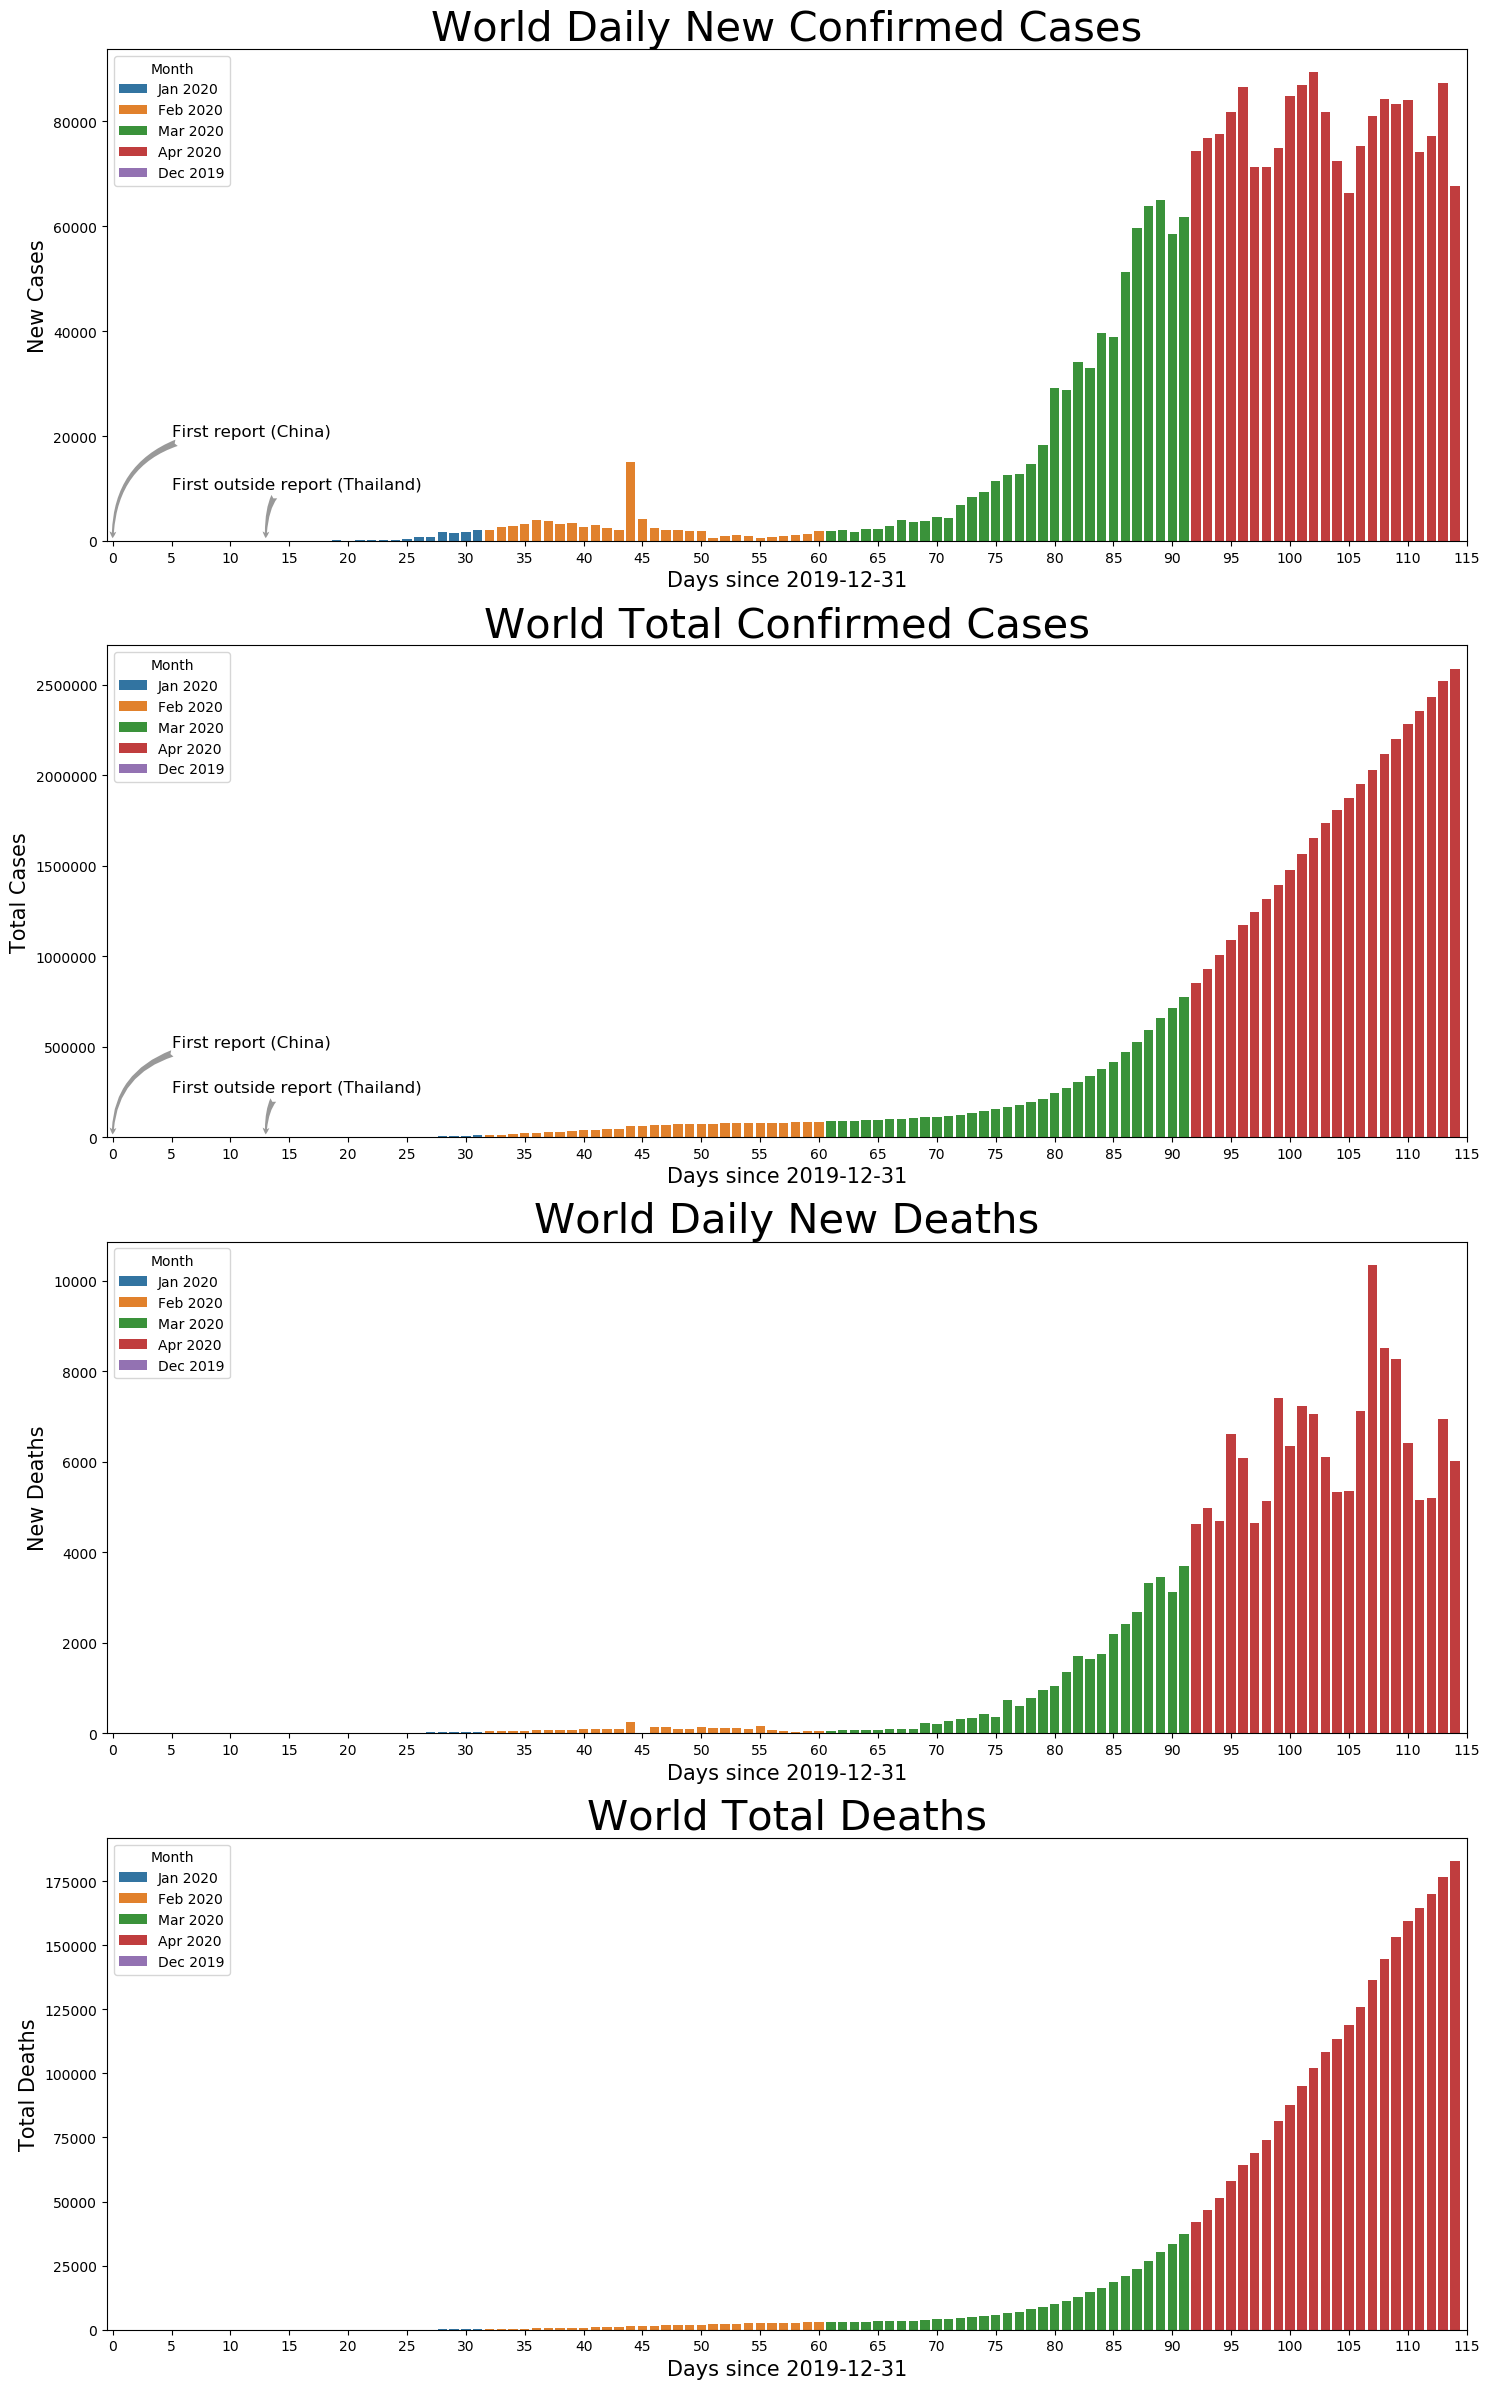

In [977]:
fig, ax = plt.subplots(4,1,figsize = (15,24))    
sns.barplot(x = "diff", y = "cases", data = total,hue='month', 
                  estimator = sum,dodge=False,ci = None, ax=ax[0])
sns.barplot(x = "diff", y = "cumsum", data = total,hue='month', 
                  estimator = sum,dodge=False,ci = None, ax=ax[1])
sns.barplot(x = "diff", y = "deaths", data = total,hue='month', 
                  estimator = sum,dodge=False,ci = None, ax=ax[2])
sns.barplot(x = "diff", y = "cumsum_deaths", data = total,hue='month', 
                  estimator = sum,dodge=False,ci = None, ax=ax[3])
ax[0].set_title('World Daily New Confirmed Cases', fontsize=30)
ax[1].set_title('World Total Confirmed Cases', fontsize=30)
ax[2].set_title('World Daily New Deaths', fontsize=30)
ax[3].set_title('World Total Deaths', fontsize=30)
ax[0].set_ylabel('New Cases', fontsize=15) 
ax[1].set_ylabel('Total Cases', fontsize=15) 
ax[2].set_ylabel('New Deaths', fontsize=15) 
ax[3].set_ylabel('Total Deaths', fontsize=15)
   
for i in (0,1,2,3):
    ax[i].set_xticks(np.arange(0,116,5))
    ax[i].set_xticklabels(labels=np.arange(0,116,5))
    ax[i].set_xlabel('Days since 2019-12-31', fontsize=15)
    ax[i].legend(loc = 2);leg = ax[i].get_legend(); leg.set_title("Month"); labs = leg.texts
    labs[4].set_text("Dec 2019"); labs[0].set_text("Jan 2020")
    labs[1].set_text("Feb 2020"); labs[2].set_text("Mar 2020")
    labs[3].set_text("Apr 2020"); 

ax[0].annotate("First report (China)", xy=(0, 0), xytext=(5, 20000),fontsize=12,
               arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))  
ax[0].annotate("First outside report (Thailand)", xy=(13, 0), xytext=(5, 10000),fontsize=12,
               arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))  
ax[1].annotate("First report (China)", xy=(0, 0), xytext=(5, 500000),fontsize=12,
               arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))  
ax[1].annotate("First outside report (Thailand)", xy=(13, 0), xytext=(5, 250000),fontsize=12,
               arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))  
fig.tight_layout()

可以看到，全球总确诊数从三月中旬开始快速增长。而全球每日新增确诊数在三月份增速很大，到了四月份增速在0附件波动。全球死亡数和确诊数的变化类似。

### 全球疫情预测 <a name="subparagraph1"></a>
    
    接下来，本文将采用多项式回归对全球的疫情进行预测。由于我们预测的对象是全球范围，用于训练的数据应该满足各大洲的确诊数大于一定的阈值（例如100），这个时候全球才可以认为是作为一个整体。因此，我们需要先求出各大洲确诊数大于100的时间。

In [982]:
#按各大洲进行统计
continent = df[['date','cases','deaths','continentExp']].groupby(['continentExp','date'],as_index = False).sum()
continent['cumsum'] = continent.groupby(['continentExp']).cumsum().cases
continent['cumsum_deaths'] = continent.groupby(['continentExp']).cumsum().deaths
continent['diff'] = [(i - pd.to_datetime('2019-12-31')).days for i in continent['date'] ]
continent['month'] = [i.month for i in continent['date']]
continent

,continentExp,date,cases,deaths,cumsum,cumsum_deaths,diff,month
0,Africa,2019-12-31,0,0,0,0,0,12
1,Africa,2020-01-01,0,0,0,0,1,1
2,Africa,2020-01-02,0,0,0,0,2,1
3,Africa,2020-01-03,0,0,0,0,3,1
4,Africa,2020-01-04,0,0,0,0,4,1
...,...,...,...,...,...,...,...,...
634,Other,2020-02-28,0,0,705,4,59,2
635,Other,2020-02-29,0,2,705,6,60,2
636,Other,2020-03-01,0,0,705,6,61,3
637,Other,2020-03-02,0,0,705,6,62,3


上表中'Other'数据实为日本钻石公主号邮轮的数据，由于它完全与世界隔离，因此我们应该在训练集中将其去掉。

In [983]:
#求各大洲开始时间以及确诊大于100时间
conti = ['Asia','America','Europe','Oceania','Other','Africa']; 
t0 = list(str('a') * 6); t100 = list(str('a') * 6)
for i in range(len(conti)):
    t0[i] = continent[(continent['continentExp']==conti[i])&(continent['cumsum']>0)].date.min().strftime('%Y-%m-%d')
    t100[i] = continent[(continent['continentExp']==conti[i])&(continent['cumsum']>100)].date.min().strftime('%Y-%m-%d')
    print(conti[i],'> 0:   ',t0[i],', ',
          (pd.to_datetime(t0[i]) - pd.to_datetime('2019-12-31')).days,'days after 2019-12-31')
    print(conti[i],'> 100: ',t100[i],', ',
          (pd.to_datetime(t100[i]) - pd.to_datetime('2019-12-31')).days,'days after 2019-12-31')
    print('\n')

Asia > 0:    2019-12-31 ,  0 days after 2019-12-31
Asia > 100:  2020-01-19 ,  19 days after 2019-12-31


America > 0:    2020-01-21 ,  21 days after 2019-12-31
America > 100:  2020-03-02 ,  62 days after 2019-12-31


Europe > 0:    2020-01-25 ,  25 days after 2019-12-31
Europe > 100:  2020-02-23 ,  54 days after 2019-12-31


Oceania > 0:    2020-01-25 ,  25 days after 2019-12-31
Oceania > 100:  2020-03-10 ,  70 days after 2019-12-31


Other > 0:    2020-02-05 ,  36 days after 2019-12-31
Other > 100:  2020-02-11 ,  42 days after 2019-12-31


Africa > 0:    2020-02-15 ,  46 days after 2019-12-31
Africa > 100:  2020-03-11 ,  71 days after 2019-12-31




由于轮船解散为3月10日，各大洲确诊数大于100为3月11日，因此我们只需要用3月11日之后的数据进行拟合。3月11日至4月23日一共44个数据点，选择44*80%大约为35个数据为训练集，剩下9个作为验证集。多项式的系数最高设为5，防止因为引入过多的参数而导致过拟合。接下来，我们将依次用2阶到5阶的多项式来对全球确诊数的训练集进行拟合，最后通过预测值在验证集上的均方根误差RMSE和回归系数R^2来选择最好的拟合模型。

In [984]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
train = total[total['date']>='2020-03-11'][0:36]; 
test = total[total['date']>='2020-03-11'][36:]
X_train = train['diff'][:, np.newaxis]; Y_train = train['cumsum'][:, np.newaxis]
X_test = test['diff'][:, np.newaxis]; Y_test = test['cumsum'][:, np.newaxis]

for i in (2,4,5,3):
    polynomial_features= PolynomialFeatures(degree=i)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.fit_transform(X_test)
    model_total = sm.OLS(Y_train, X_train_poly).fit()
    y_train_pred = model_total.predict(X_train_poly)
    y_test_pred = model_total.predict(X_test_poly)
    print('order = ',i,', rmse = ',np.sqrt(mean_squared_error(test['cumsum'],y_test_pred)))
    print('order = ',i,', r2 = ',r2_score(test['cumsum'],y_test_pred))
    print('\n')
model_total.summary()

order =  2 , rmse =  236081.8860963121
order =  2 , r2 =  -0.658153911572323


order =  4 , rmse =  194950.97454227586
order =  4 , r2 =  -0.13070764485617348


order =  5 , rmse =  69586.83130315716
order =  5 , r2 =  0.8559366102318076


order =  3 , rmse =  26140.941946348037
order =  3 , r2 =  0.9796697849443129




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.047e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-52
Time:                        00:30:53   Log-Likelihood:                -393.40
No. Observations:                  36   AIC:                             794.8
Df Residuals:                      32   BIC:                             801.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.626e+07   1.85e+06     14.223      0.000    2.25e+07       3e+07
x1         -8.661e+05   6.35e+04    -13.647      0.000   -9.95e+05   -7.37e+05
x2          9067.2970    721.759     12.563      0.000    7597.121    1.05e+04
x3           -28.8530      2.717    -10.620      0.000     -34.387     -23.319
==============================================================================
Omnibus:                        1.734   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.549
Skew:                          -0.385   Prob(JB):                        0.461
Kurtosis:                       2.337   Cond. No.                     5.92e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

可以看到3阶的多项式模型在验证集上的RMSE最小，R^2最大，因此预测效果最好。上面结果中，2阶和4阶的多项式模型在验证集上的回归系数为负数，这说明这两个模型的表现还不如平均值近似。另外，结果中提示“条件数（condition number）太大，可能是由变量之间有很强的关联造成的”，这是因为我们采用多变量线性回归的方法来拟合多项式模型，显然，每个变量都是由时间变量t的n次方，因此是强关联的。接下来，画图展示拟合模型和真实数据的重合程度：

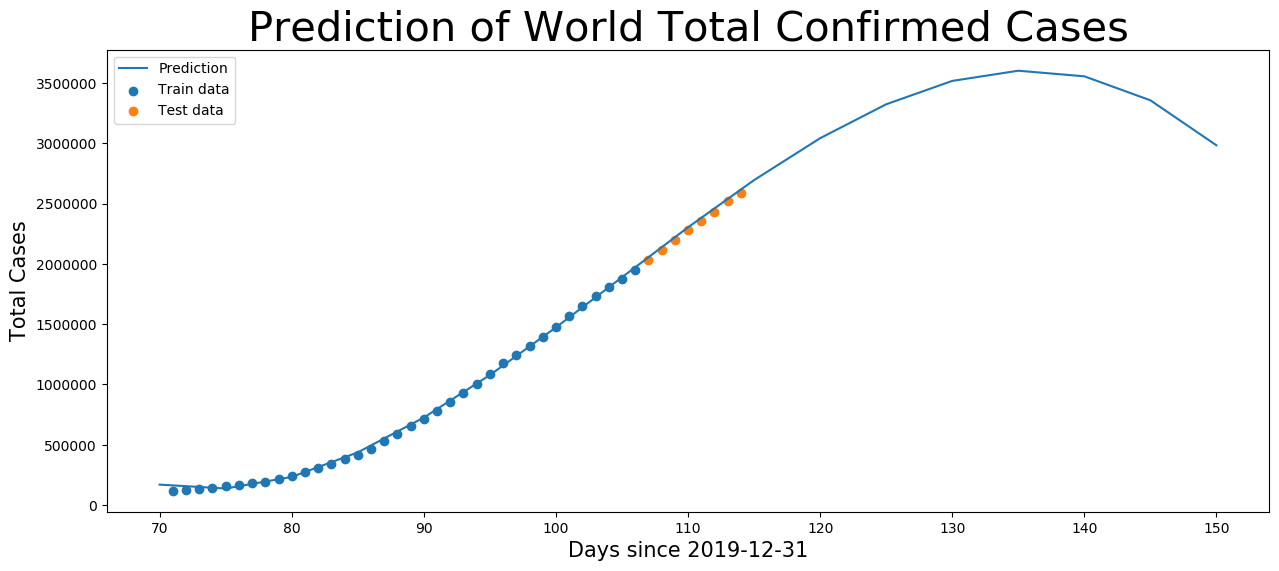

In [986]:
x = np.arange(70,151,5)[:, np.newaxis]
x_poly = polynomial_features.fit_transform(x)
pred = model_total.predict(x_poly)

fig, ax = plt.subplots(figsize = (15,6))   
ax.scatter(X_train ,Y_train,label = 'Train data')
ax.scatter(X_test ,Y_test,label = 'Test data')
ax.plot(x,pred,label = 'Prediction')
ax.set_title('Prediction of World Total Confirmed Cases', fontsize=30)
ax.set_ylabel('Total Cases', fontsize=15) 
ax.set_xlabel('Days since 2019-12-31', fontsize=15) 
ax.legend()

上图蓝色点为训练集，黄点为验证集，蓝线为3阶多项式模型。我们可以看到，该模型预测距离2019年12月31日大概135天时，总确诊数开始下降。由于传染病模型一般与指数增长有关，多项式模型只能在一定的范围内进行预测。另外，由于上图后期表现的下降行为是3阶多项式函数自身带来的，因此我们将其预测能力限定为10天：

In [987]:
#预测未来10天的总确诊数
x = np.arange(115,126)[:, np.newaxis]
x_poly = polynomial_features.fit_transform(x)
total_pred = model_total.predict(x_poly)
total_pred

array([2694775.12350734, 2768494.19841819, 2840266.16908678,
       2909917.91742454, 2977276.32534289, 3042168.27475323,
       3104420.647567  , 3163860.32569562, 3220314.19105049,
       3273609.12554304, 3323572.01108472])

我们可以用同样的方法对全球总死亡人数进行预测：

In [988]:
train = total[total['date']>='2020-03-11'][0:36]; 
test = total[total['date']>='2020-03-11'][36:]
X_train = train['diff'][:, np.newaxis]; Y_train = train['cumsum_deaths'][:, np.newaxis]
X_test = test['diff'][:, np.newaxis]; Y_test = test['cumsum_deaths'][:, np.newaxis]

for i in (5,4,3,2):
    polynomial_features= PolynomialFeatures(degree=i)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.fit_transform(X_test)
    model_death = sm.OLS(Y_train, X_train_poly).fit()
    y_train_pred = model_death.predict(X_train_poly)
    y_test_pred = model_death.predict(X_test_poly)
    print('order = ',i,', rmse = ',
          np.sqrt(mean_squared_error(test['cumsum_deaths'],y_test_pred)))
    print('order = ',i,', r2 = ',r2_score(test['cumsum_deaths'],y_test_pred))
    print('\n')
model_death.summary()

order =  5 , rmse =  28217.46205539407
order =  5 , r2 =  -2.635847774659255


order =  4 , rmse =  13361.006478013676
order =  4 , r2 =  0.18483008765771936


order =  3 , rmse =  8921.404315303826
order =  3 , r2 =  0.6365570605355955


order =  2 , rmse =  8630.458771862423
order =  2 , r2 =  0.6598757814303161




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.340e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.57e-49
Time:                        01:03:19   Log-Likelihood:                -310.34
No. Observations:                  36   AIC:                             626.7
Df Residuals:                      33   BIC:                             631.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.892e+05   1.88e+04     36.617      0.000    6.51e+05    7.27e+05
x1          -1.84e+04    429.402    -42.850      0.000   -1.93e+04   -1.75e+04
x2           123.7140      2.423     51.065      0.000     118.785     128.643
==============================================================================
Omnibus:                        1.811   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.236
Skew:                          -0.179   Prob(JB):                        0.539
Kurtosis:                       2.166   Cond. No.                     6.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

可以看出，对于死亡人数的预测，2阶多项式模型的效果要好一些。同样，画图展示拟合模型和真实数据的重合程度：

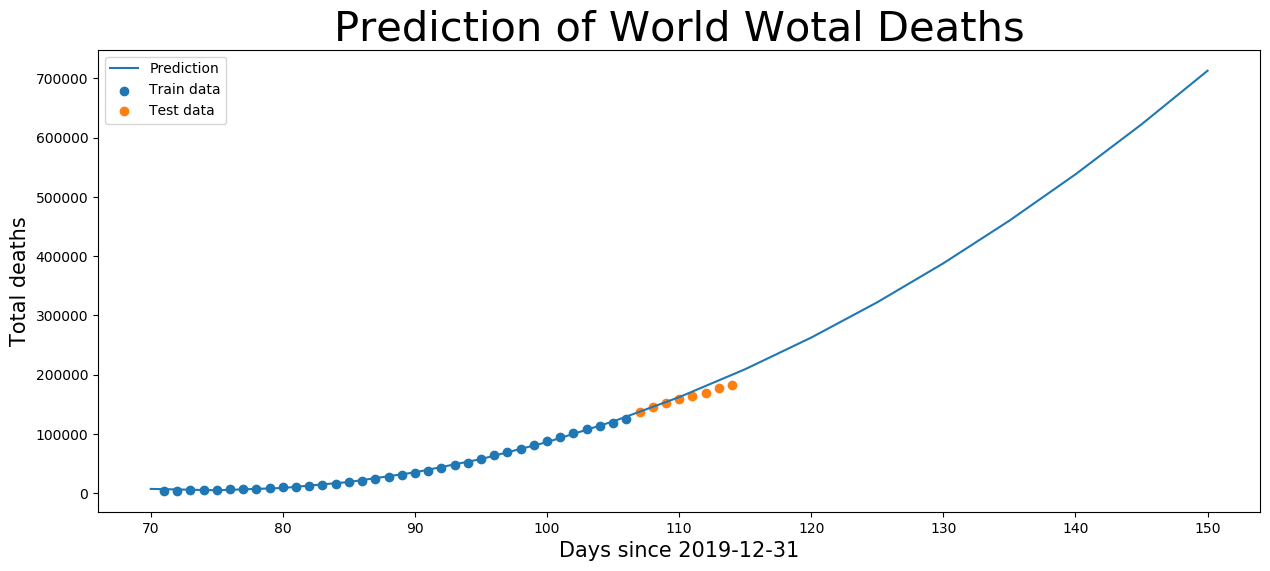

In [990]:
x = np.arange(70,151,5)[:, np.newaxis]
x_poly = polynomial_features.fit_transform(x)
pred = model_death.predict(x_poly)

fig, ax = plt.subplots(figsize = (15,6))   
ax.scatter(X_train ,Y_train,label = 'Train data')
ax.scatter(X_test ,Y_test,label = 'Test data')
ax.plot(x,pred,label = 'Prediction')
ax.set_title('Prediction of World Wotal Deaths', fontsize=30)
ax.set_ylabel('Total deaths', fontsize=15) 
ax.set_xlabel('Days since 2019-12-31', fontsize=15) 
ax.legend()

最后，我们将4月23日未来10天的全球总确诊数和全球总死亡数的预测进行汇总：

In [991]:
#预测未来10天的总死亡数以及总确诊数
x = np.arange(115,126)[:, np.newaxis]
x_poly = polynomial_features.fit_transform(x)
death_pred = model_death.predict(x_poly)
#汇总
date = np.array([pd.Timestamp('2019-12-31') + datetime.timedelta(days=int(i)) for i in x.ravel()])
prediction = pd.DataFrame(data=[date,total_pred,death_pred],
                          index=['date','world total cases prediction','world total deaths prediction'])
prediction.iloc[0,:] = prediction.iloc[0,:].dt.strftime('%m-%d')
prediction.iloc[1,:] = prediction.iloc[1,:].astype('int64')
prediction.columns = [''] * len(prediction.columns)
prediction

,,,,,,,,,,,
date,04-24,04-25,04-26,04-27,04-28,04-29,04-30,05-01,05-02,05-03,05-04
world total cases prediction,2694775,2768494,2840266,2909917,2977276,3042168,3104420,3163860,3220314,3273609,3323572
world total deaths prediction,209288,219467,229892,240565,251485,262653,274069,285731,297641,309799,322204


## 各大洲疫情变化 <a name="paragraph2"></a>

统计各大洲到4.23号截至报告过病例的国家：

In [992]:
#统计各大洲到4.23号截至报告过病例的国家
for i in range(len(conti1)):
    print('\nAffected countries in ',conti1[i],':\n\n ',
          df[(df['continentExp']==conti1[i])&(df['cases']>0)].countriesAndTerritories.unique())


Affected countries in  Asia :

  ['Afghanistan' 'Bahrain' 'Bangladesh' 'Bhutan' 'Brunei_Darussalam'
 'Cambodia' 'China' 'India' 'Indonesia' 'Iran' 'Iraq' 'Israel' 'Japan'
 'Jordan' 'Kazakhstan' 'Kuwait' 'Kyrgyzstan' 'Laos' 'Lebanon' 'Malaysia'
 'Maldives' 'Mongolia' 'Myanmar' 'Nepal' 'Oman' 'Pakistan' 'Palestine'
 'Philippines' 'Qatar' 'Saudi_Arabia' 'Singapore' 'South_Korea'
 'Sri_Lanka' 'Syria' 'Taiwan' 'Thailand' 'Timor_Leste' 'Turkey'
 'United_Arab_Emirates' 'Uzbekistan' 'Vietnam' 'Yemen']

Affected countries in  America :

  ['Anguilla' 'Antigua_and_Barbuda' 'Argentina' 'Aruba' 'Bahamas' 'Barbados'
 'Belize' 'Bermuda' 'Bolivia' 'Bonaire, Saint Eustatius and Saba' 'Brazil'
 'British_Virgin_Islands' 'Canada' 'Cayman_Islands' 'Chile' 'Colombia'
 'Costa_Rica' 'Cuba' 'Curaçao' 'Dominica' 'Dominican_Republic' 'Ecuador'
 'El_Salvador' 'Falkland_Islands_(Malvinas)' 'Greenland' 'Grenada'
 'Guatemala' 'Guyana' 'Haiti' 'Honduras' 'Jamaica' 'Mexico' 'Montserrat'
 'Nicaragua' 'Panama' 'Paragu

统计各大洲最先报告病例的时间及国家：

In [993]:
for i in (0,1,2,3,5):
    print('\nFirst affected country in ',conti[i],': ',
          df[(df['continentExp']==conti[i])&(df['cases']>0)].sort_values(by=['date']).iloc[0,:].countriesAndTerritories
         ,', ',df[(df['continentExp']==conti[i])&(df['cases']>0)].sort_values(by=['date']).iloc[0,:].date.strftime('%Y-%m-%d')
         ,',',(pd.to_datetime(t0[i]) - pd.to_datetime('2019-12-31')).days,'days')


First affected country in  Asia :  China ,  2019-12-31 , 0 days

First affected country in  America :  United_States_of_America ,  2020-01-21 , 21 days

First affected country in  Europe :  France ,  2020-01-25 , 25 days

First affected country in  Oceania :  Australia ,  2020-01-25 , 25 days

First affected country in  Africa :  Egypt ,  2020-02-15 , 46 days


各大洲疫情画图：

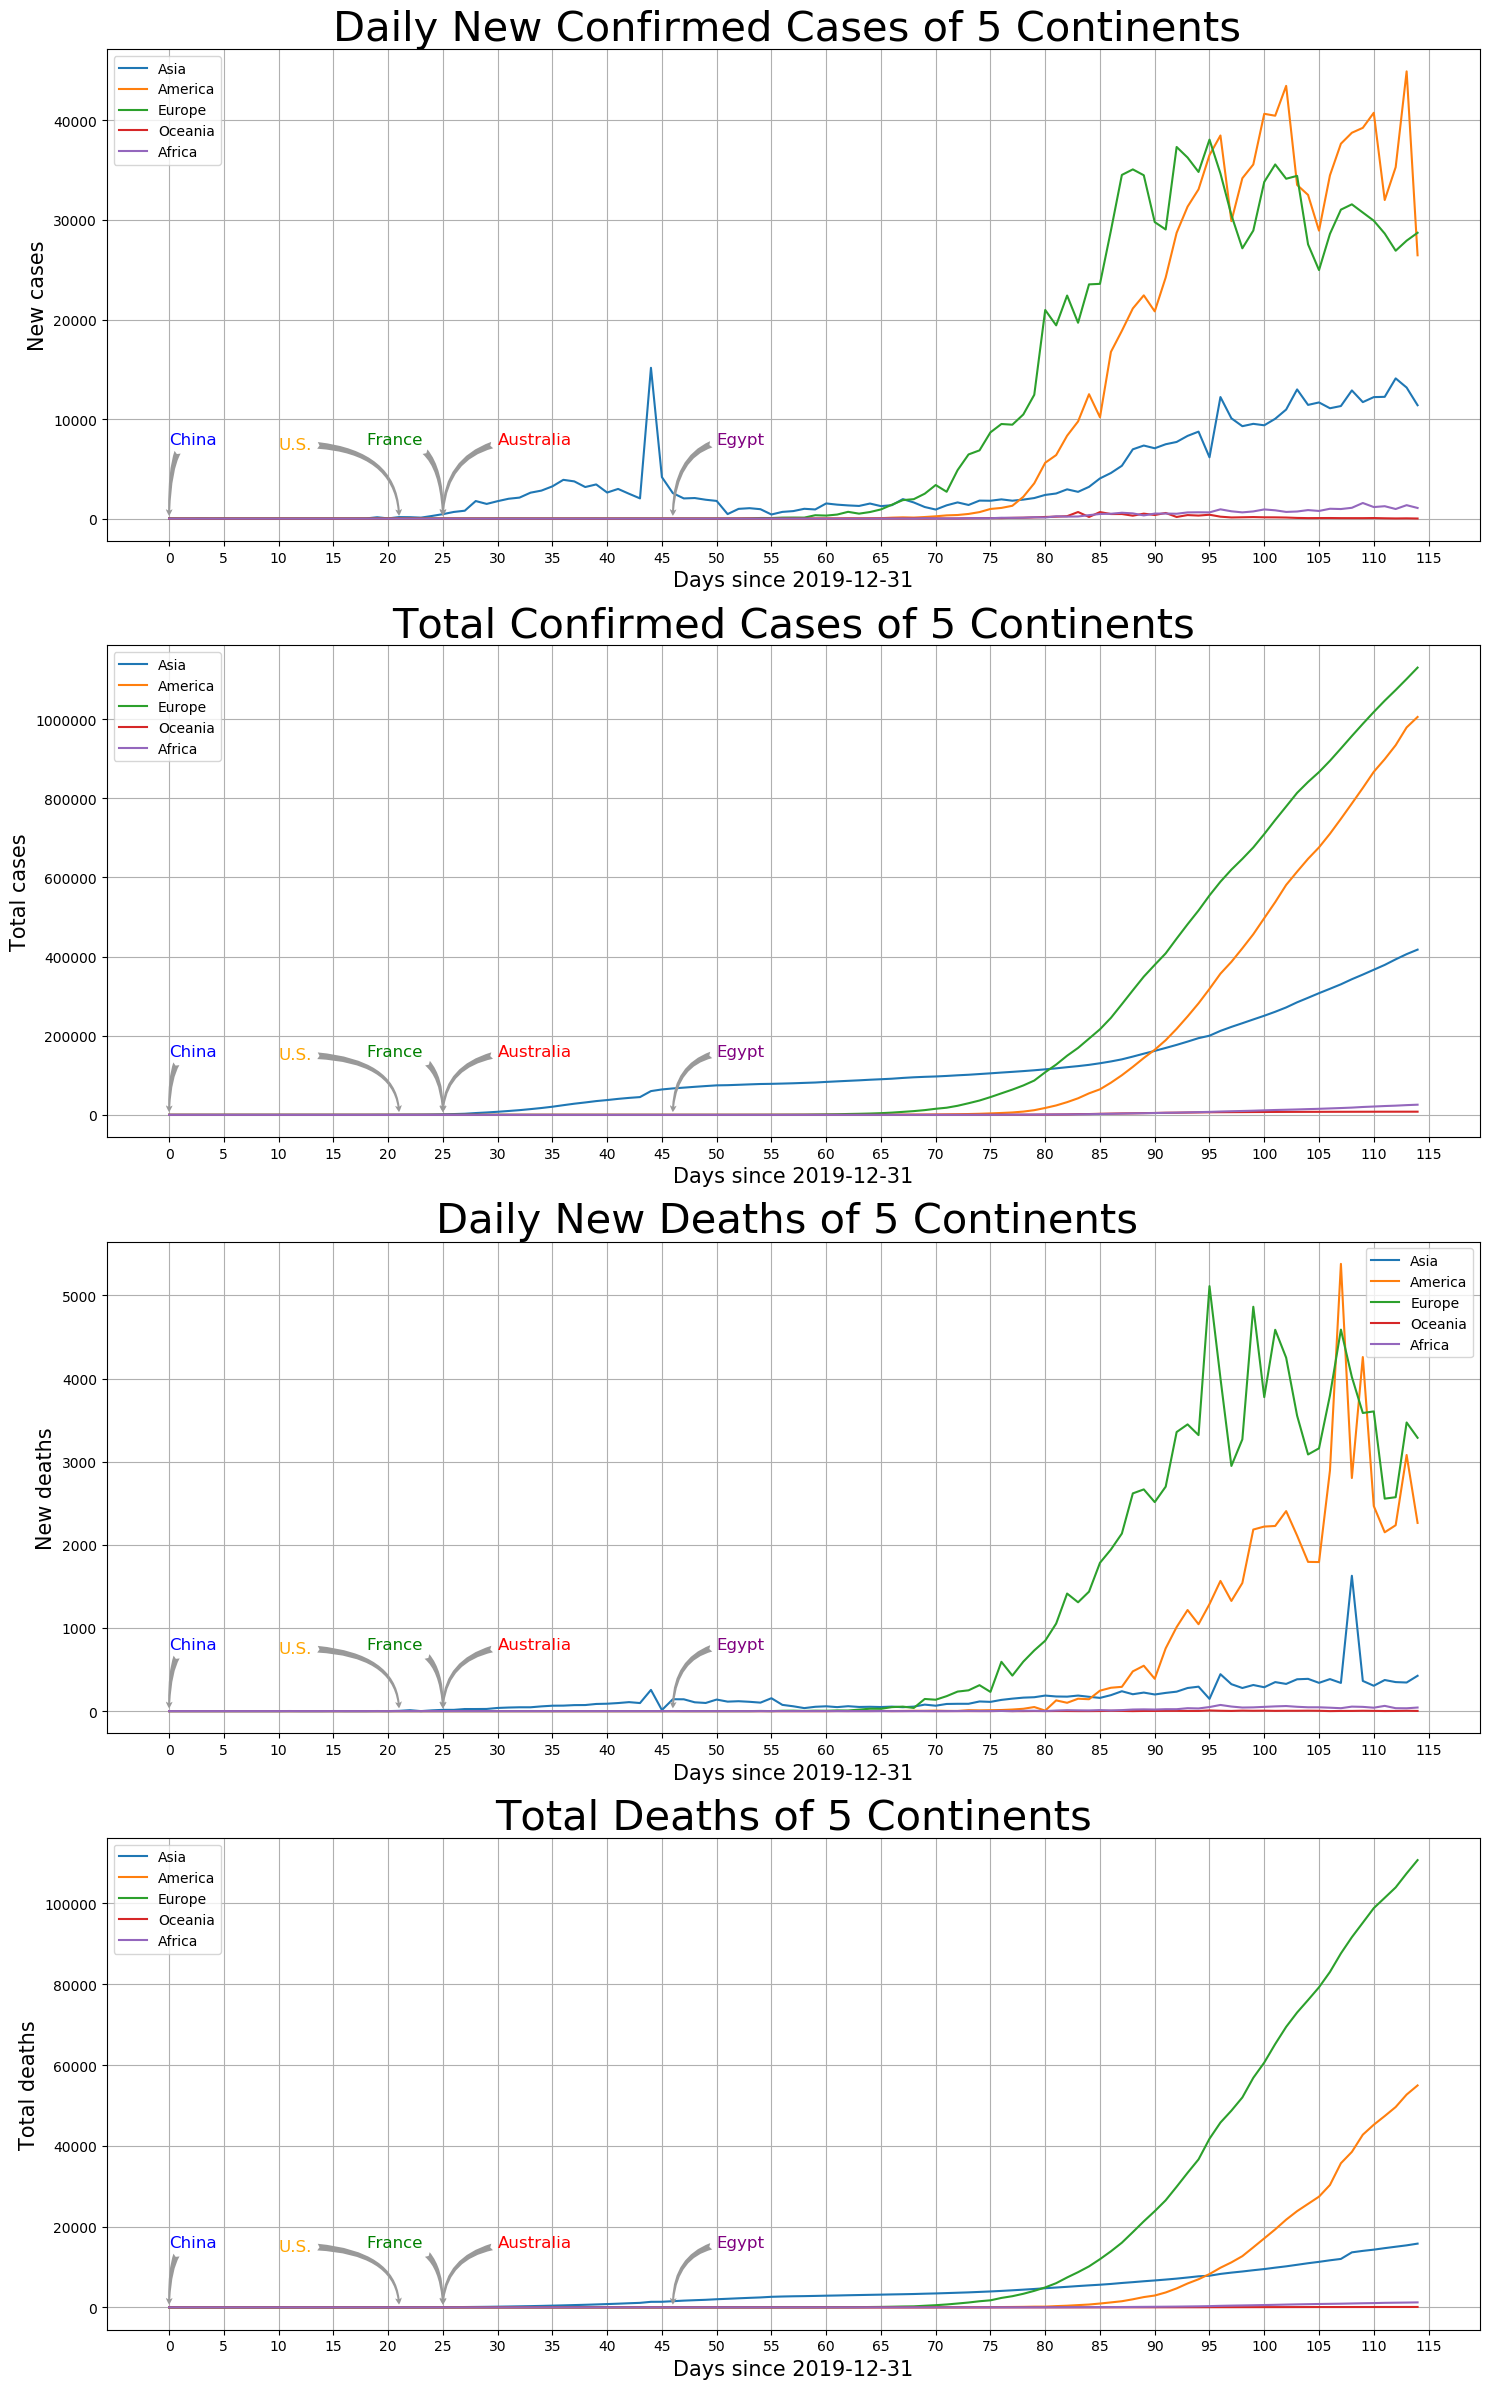

In [464]:
a = [(0,0),(21,0),(25,0),(25,0),(46,0)]; 
b = [[(0,7500),(0,150000),(0,750),(0,15000)],[(10,7000),(10,140000),(10,700),(10,14000)],
     [(18,7500),(18,150000),(18,750),(18,15000)],[(30,7500),(30,150000),(30,750),(30,15000)],
     [(50,7500),(50,150000),(50,750),(50,15000)]];
c = ['China','U.S.','France','Australia','Egypt'];
d = ['blue','orange','green','red','purple'];
e = ['cases','cumsum','deaths','cumsum_deaths'];
f = ['New cases','Total cases','New deaths','Total deaths'];
g = ['Daily New Confirmed Cases of 5 Continents ','Total Confirmed Cases of 5 Continents',
     'Daily New Deaths of 5 Continents ','Total Deaths of 5 Continents']
fig, ax = plt.subplots(4,1,figsize = (15,24))  
for j in range(4):
    for i in range(len(conti1)):
        ax[j].plot(continent[continent['continentExp']==conti1[i]]['diff'],
                      continent[continent['continentExp']==conti1[i]][e[j]],
            label = conti1[i])
        ax[j].annotate(c[i], xy=a[i], xytext=b[i][j],fontsize=12,color=d[i],arrowprops=dict(arrowstyle='fancy',
               fc="0.6", ec="none",connectionstyle="angle3,angleA=0,angleB=-90")) 
    ax[j].set_xticks(np.arange(0,116,5))
    ax[j].set_xticklabels(labels=np.arange(0,116,5))
    ax[j].set_xlabel('Days since 2019-12-31', fontsize=15)
    ax[j].set_ylabel(f[j], fontsize=15) 
    ax[j].set_title(g[j], fontsize=30)
    ax[j].grid(True); ax[j].legend()
fig.tight_layout()

上图由于美洲数据的量级很大，不能展现量级小一些的大洋洲和非洲的细节，下面单独画出：

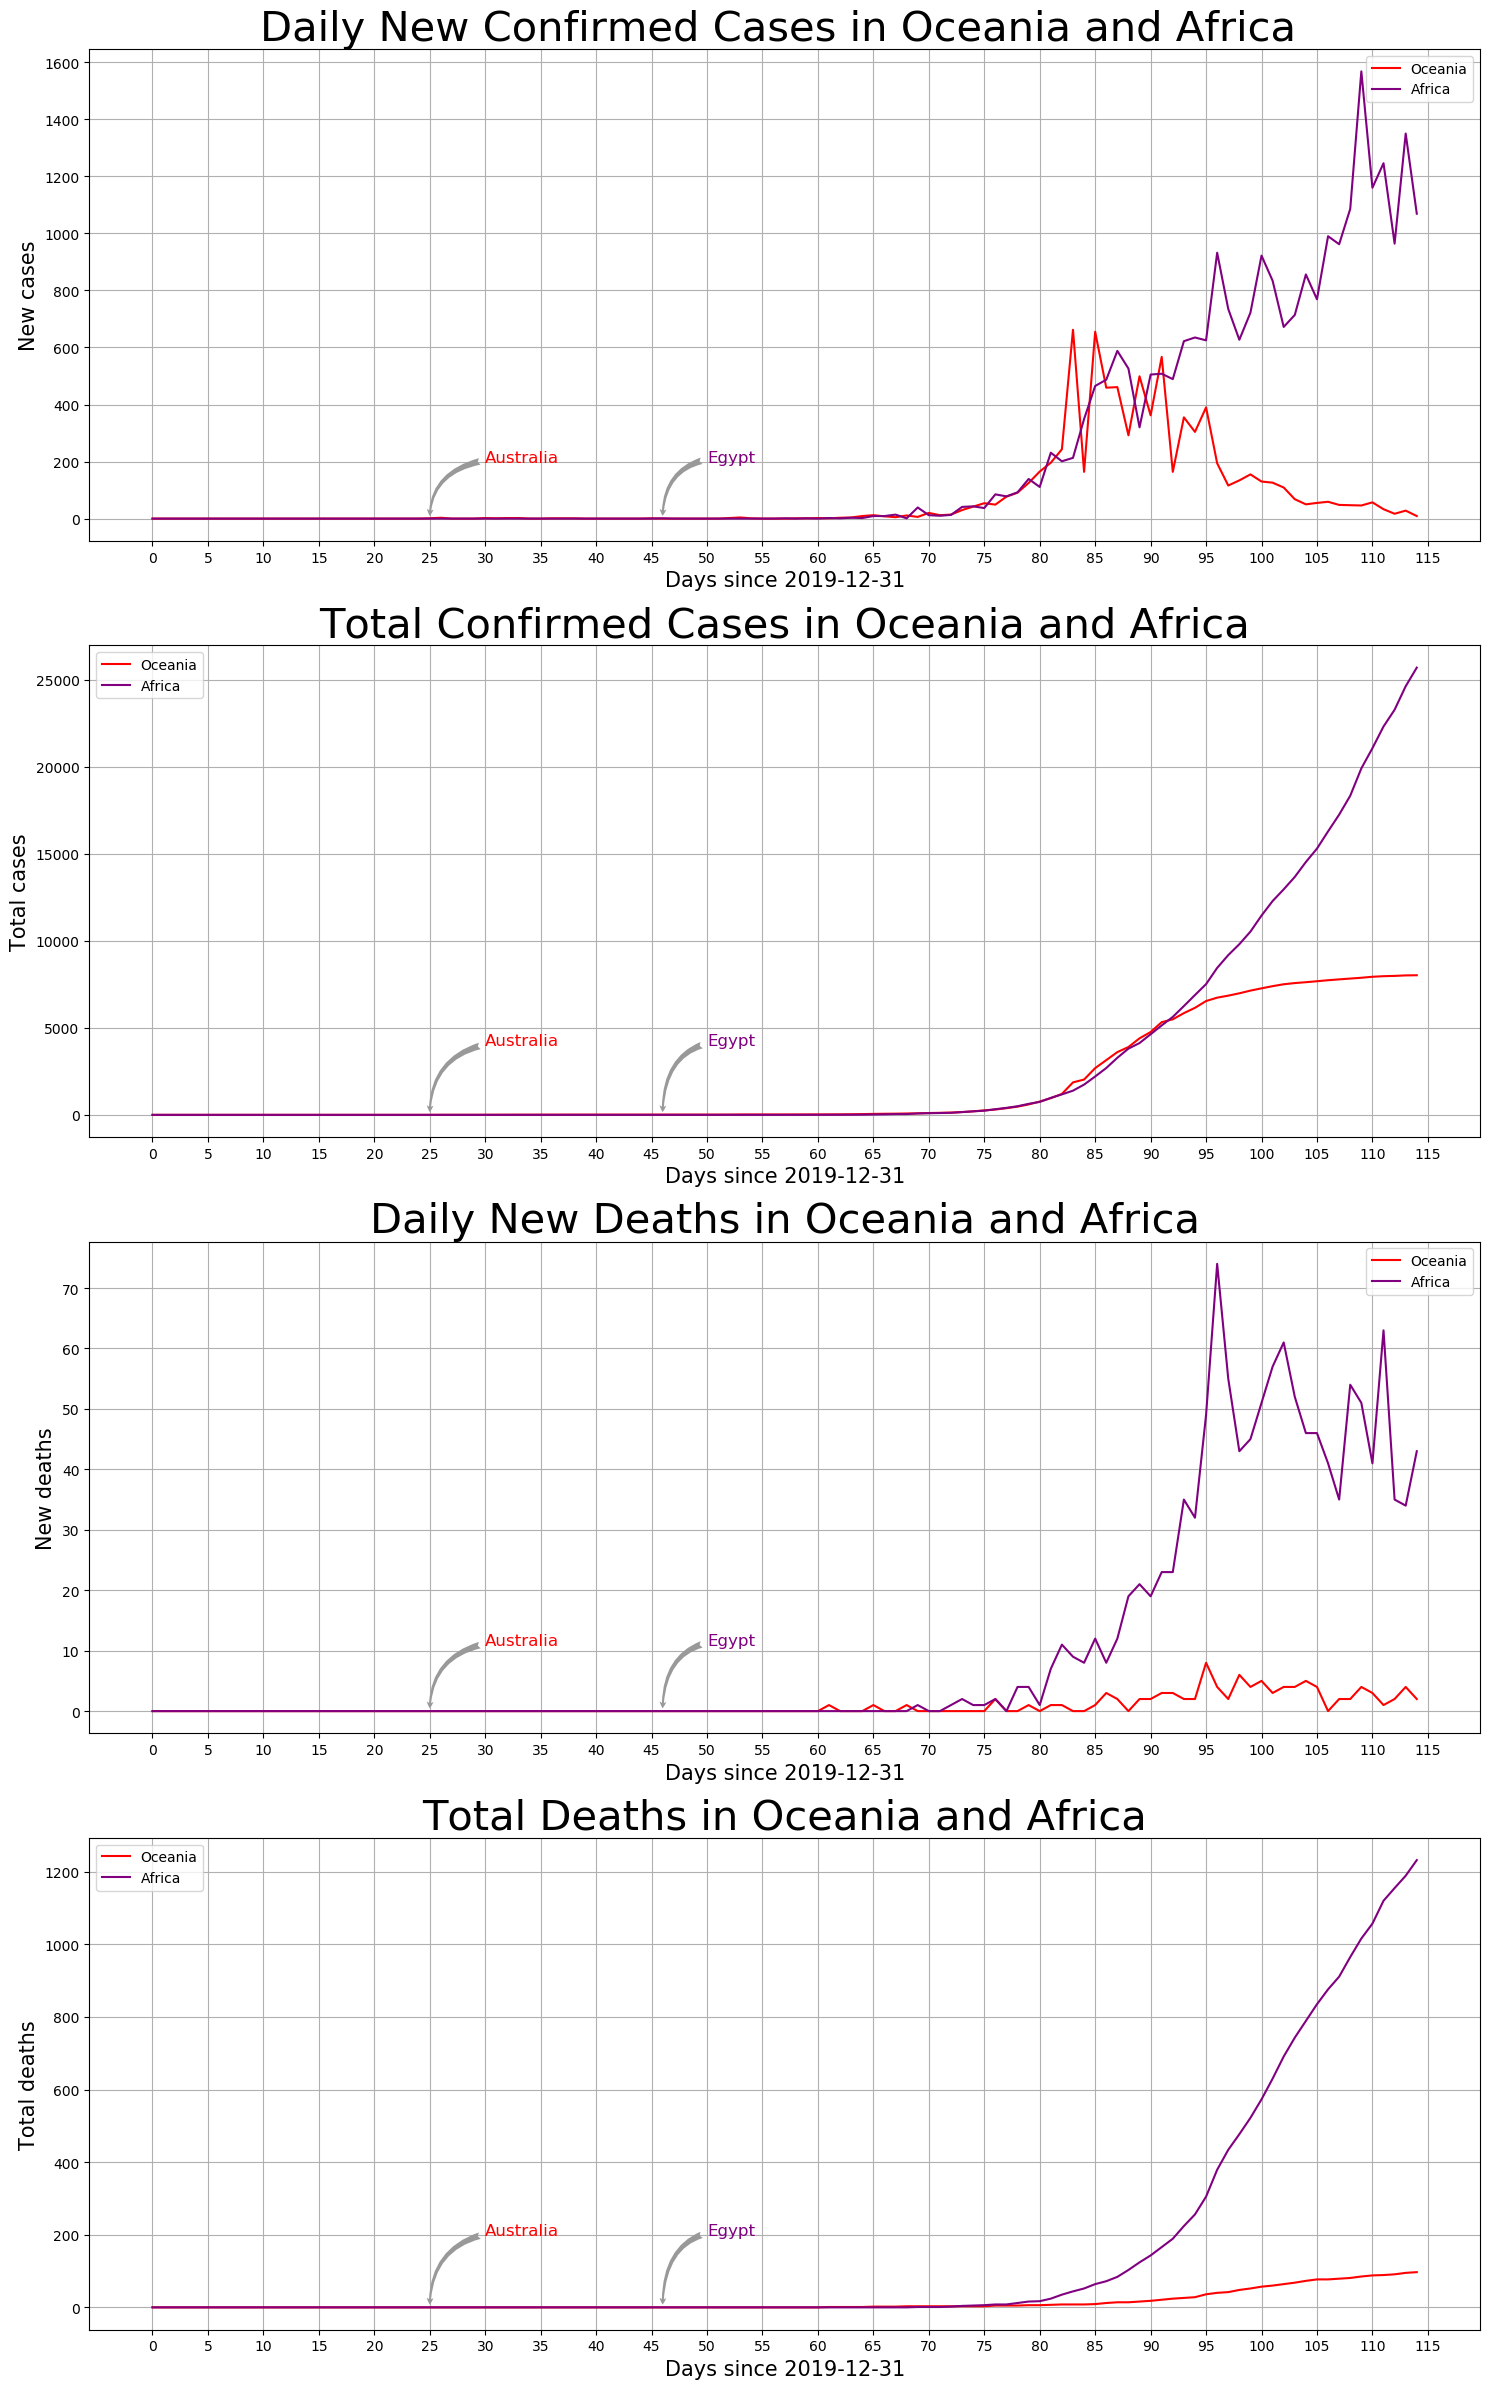

In [994]:
a = [(0,0),(21,0),(25,0),(25,0),(46,0)]; 
b = [[(0,7500),(0,150000),(0,750),(0,15000)],[(10,7000),(10,140000),(10,700),(10,14000)],
     [(18,7500),(18,150000),(18,750),(18,15000)],[(30,200),(30,4000),(30,11),(30,200)],
     [(50,200),(50,4000),(50,11),(50,200)]];
c = ['China','U.S.','France','Australia','Egypt'];
d = ['blue','orange','green','red','purple'];
e = ['cases','cumsum','deaths','cumsum_deaths'];
f = ['New cases','Total cases','New deaths','Total deaths'];
g = ['Daily New Confirmed Cases in Oceania and Africa ','Total Confirmed Cases in Oceania and Africa',
     'Daily New Deaths in Oceania and Africa','Total Deaths in Oceania and Africa']
fig, ax = plt.subplots(4,1,figsize = (15,24))  
for j in range(4):
    for i in (3,4):
        ax[j].plot(continent[continent['continentExp']==conti1[i]]['diff'],
                      continent[continent['continentExp']==conti1[i]][e[j]],
            label = conti1[i],color=d[i])
        ax[j].annotate(c[i], xy=a[i], xytext=b[i][j],fontsize=12,color=d[i],arrowprops=dict(arrowstyle='fancy',
               fc="0.6", ec="none",connectionstyle="angle3,angleA=0,angleB=-90")) 
    ax[j].set_xticks(np.arange(0,116,5))
    ax[j].set_xticklabels(labels=np.arange(0,116,5))
    ax[j].set_xlabel('Days since 2019-12-31', fontsize=15)
    ax[j].set_ylabel(f[j], fontsize=15) 
    ax[j].set_title(g[j], fontsize=30)
    ax[j].grid(True); ax[j].legend()
fig.tight_layout()

## 各国疫情变化 <a name="paragraph3"></a>

计算各个国家的确诊率以及死亡率：

In [995]:
country0 = df[['countriesAndTerritories','cases','deaths']].groupby(['countriesAndTerritories'],
            as_index=False).sum().sort_values(by=['cases'],ascending=False) 
country = pd.merge(country0,df[['countriesAndTerritories','popData2018']],
                  how='right',on ='countriesAndTerritories' )
country.drop_duplicates(inplace = True);country.reset_index(drop = True,inplace = True);
country.iloc[0,0] = 'U.S.'; country.iloc[4,0] = 'U.K.'; 
world = pd.DataFrame(data=[['World',2588068,182808,7748315400]],
                     columns=['countriesAndTerritories','cases','deaths','popData2018'])
country = pd.concat([country,world]);
country.sort_values(by=['cases'],ascending=False,inplace = True)
country.reset_index(drop = True,inplace = True);
country['rate(%)'] = (100*country['cases']/country['popData2018']).map('{:,.2f}'.format).astype('float64')
country['death_rate(%)'] = (100*country['deaths']/country['cases']).map('{:,.2f}'.format).astype('float64')
country.head(21)

,countriesAndTerritories,cases,deaths,popData2018,rate(%),death_rate(%)
0,World,2588068,182808,7.748315e+09,0.03,7.06
1,U.S.,842629,46784,3.271674e+08,0.26,5.55
2,Spain,208389,21717,4.672375e+07,0.45,10.42
3,Italy,187327,25085,6.043128e+07,0.31,13.39
4,Germany,148046,5094,8.292792e+07,0.18,3.44
5,U.K.,133495,18100,6.648899e+07,0.20,13.56
6,France,119151,21340,6.698724e+07,0.18,17.91
7,Turkey,98674,2376,8.231972e+07,0.12,2.41
8,Iran,85996,5391,8.180027e+07,0.11,6.27
9,China,83876,4636,1.392730e+09,0.01,5.53


计算各个国家的（总确诊数，总死亡数，确诊率，死亡率）的前20排名汇总表：

In [996]:

country1 = country.drop(0,axis = 0)
rank_c = country1[['countriesAndTerritories','cases']].sort_values(
    by=['cases'],ascending=False).head(20); rank_c.reset_index(drop=True, inplace=True)
rank_d = country1[['countriesAndTerritories','deaths']].sort_values(
    by=['deaths'],ascending=False).head(20); rank_d.reset_index(drop=True, inplace=True)
rank_r = country1.dropna()[['countriesAndTerritories','rate(%)']].sort_values(
    by=['rate(%)'],ascending=False).head(20); rank_r.reset_index(drop=True, inplace=True)
rank_dr = country1.dropna()[['countriesAndTerritories','death_rate(%)']].sort_values(
    by=['death_rate(%)'],ascending=False).head(20); rank_dr.reset_index(drop=True, inplace=True)
rank_r.iloc[0,0] = 'cruise ship'   
rank = pd.concat([rank_c,rank_d,rank_r,rank_dr],axis = 1)
rank.index = np.arange(1,21); 
rank.columns= ['#Cases','','#Deaths','','Confirmed Rate(%)','','Death Rate(%)','']
#加入世界平均数据
World_Confirmed_Rate =np.float64('{:,.2f}'.format(100*2588068/7748315400))
World_Death_Rate = np.float64('{:,.2f}'.format(100*182808/2588068))
World = pd.DataFrame(data=[['World',2588068,'World',182808,'World',World_Confirmed_Rate,'World',World_Death_Rate]],
                     columns=['#Cases','','#Deaths','','Confirmed Rate(%)','','Death Rate(%)',''])
rank = pd.concat([rank,World]); rank.sort_index(inplace = True)
rank

,#Cases,,#Deaths,,Confirmed Rate(%),,Death Rate(%),
0,World,2588068,World,182808,World,0.03,World,7.06
1,U.S.,842629,U.S.,46784,cruise ship,23.20,British_Virgin_Islands,20.00
2,Spain,208389,Italy,25085,San_Marino,1.44,Nicaragua,20.00
3,Italy,187327,Spain,21717,Andorra,0.94,France,17.91
4,Germany,148046,France,21340,Holy_See,0.90,Sint_Maarten,16.44
5,U.K.,133495,U.K.,18100,Luxembourg,0.60,Belgium,14.95
6,France,119151,Belgium,6262,Iceland,0.50,Northern_Mariana_Islands,14.29
7,Turkey,98674,Iran,5391,Spain,0.45,Mauritania,14.29
8,Iran,85996,Germany,5094,Gibraltar,0.39,Algeria,13.81
9,China,83876,China,4636,Guernsey,0.39,U.K.,13.56


计算总确诊数排名前十的国家的疫情变化表：

In [997]:

temp = df[df['countriesAndTerritories'].isin(list(country.countriesAndTerritories.head(11))+[
    'United_States_of_America','United_Kingdom'])]
top10 = temp[['date','cases','deaths','countriesAndTerritories']].groupby(['countriesAndTerritories','date'],
                                                                         as_index = False).sum()
top10['cumsum'] = top10.groupby(['countriesAndTerritories']).cumsum().cases
top10['cumsum_deaths'] = top10.groupby(['countriesAndTerritories']).cumsum().deaths
top10['diff'] = [(i - pd.to_datetime('2019-12-31')).days for i in top10['date']]
top10['death_rate(%)'] = (100*top10['cumsum_deaths']/top10['cumsum']).map('{:,.2f}'.format).astype('float64')
def converter(x):
    if x == 'United_States_of_America':
        return 'U.S.'
    if x == 'United_Kingdom':
        return 'U.K.'
    else:
        return x
top10['countriesAndTerritories'] = top10['countriesAndTerritories'].apply(converter)
top10.fillna(0,inplace = True)
top10

,countriesAndTerritories,date,cases,deaths,cumsum,cumsum_deaths,diff,death_rate(%)
0,China,2019-12-31,27,0,27,0,0,0.00
1,China,2020-01-01,0,0,27,0,1,0.00
2,China,2020-01-02,0,0,27,0,2,0.00
3,China,2020-01-03,17,0,44,0,3,0.00
4,China,2020-01-04,0,0,44,0,4,0.00
...,...,...,...,...,...,...,...,...
1071,U.S.,2020-04-19,32922,1856,735086,38910,110,5.29
1072,U.S.,2020-04-20,24601,1772,759687,40682,111,5.36
1073,U.S.,2020-04-21,28065,1857,787752,42539,112,5.40
1074,U.S.,2020-04-22,37289,2524,825041,45063,113,5.46


确诊数前五的国家以及中国（第九）的疫情画图：

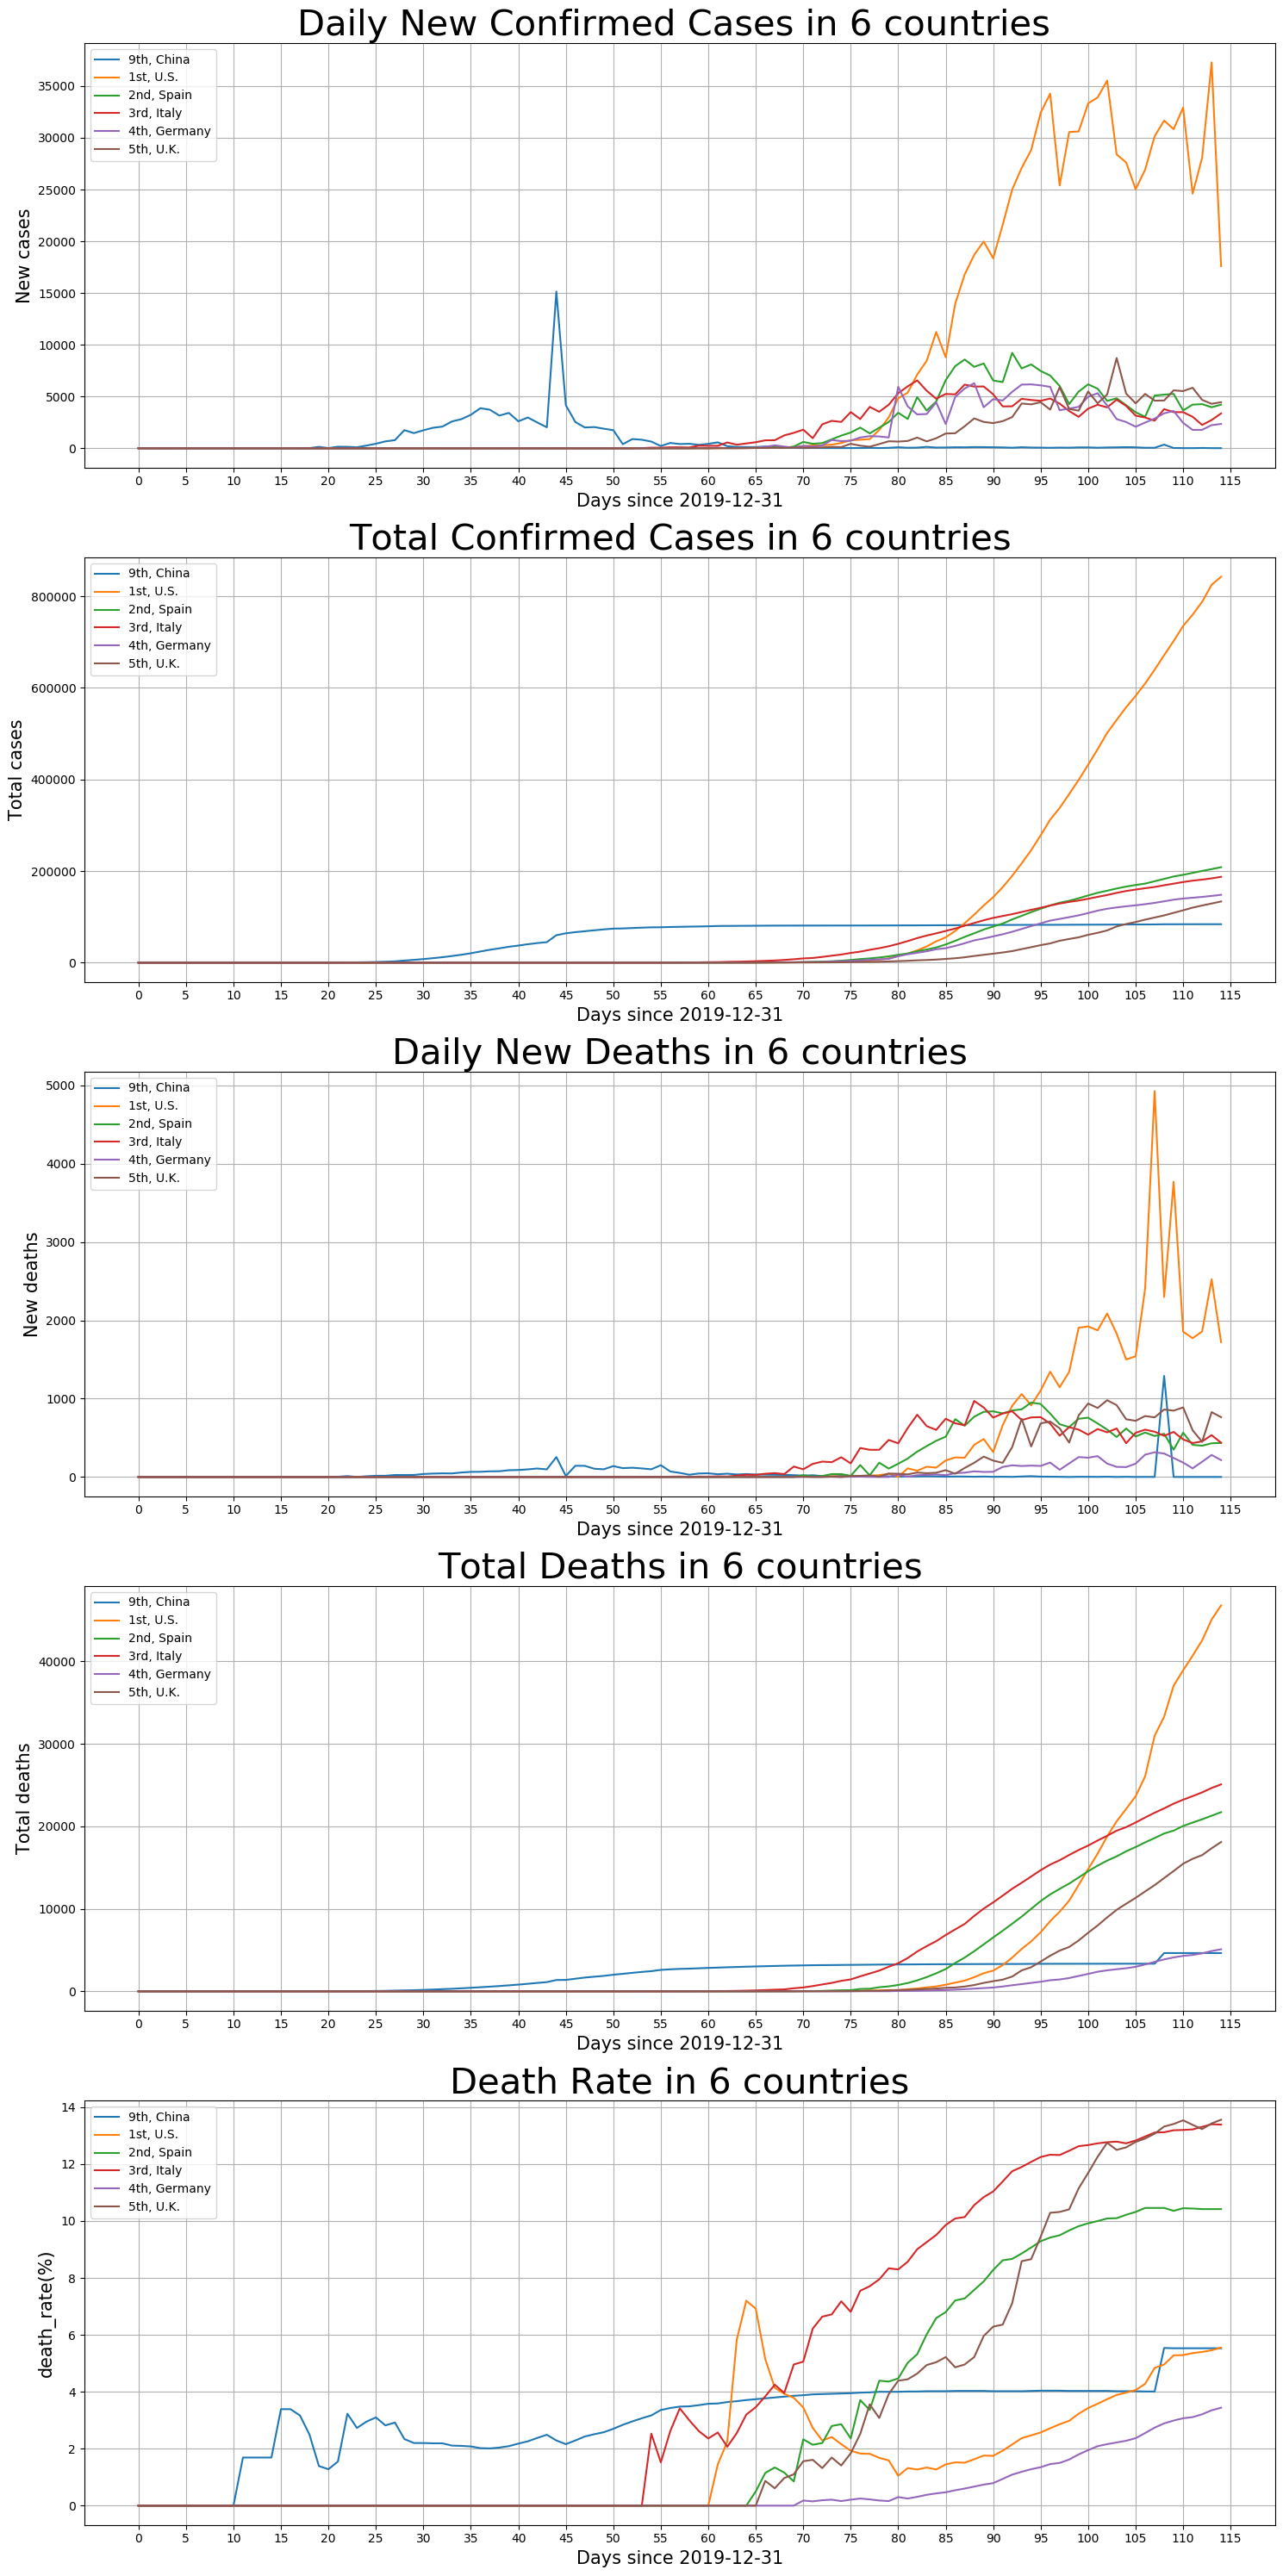

In [998]:
a = ['cases','cumsum','deaths','cumsum_deaths','death_rate(%)'];
b = ['New cases','Total cases','New deaths','Total deaths','death_rate(%)'];
c = ['Daily New Confirmed Cases in 6 countries ','Total Confirmed Cases in 6 countries',
     'Daily New Deaths in 6 countries','Total Deaths in 6 countries','Death Rate in 6 countries']
d = [9,1,2,3,4,5]; d1 = ['th, ','st, ','nd, ','rd, ','th, ','th, ']
fig, ax = plt.subplots(5,1,figsize = (15,30)) 
for j in range(5):
    for i in range(6):
        x = top10[top10['countriesAndTerritories']==country.countriesAndTerritories[d[i]]]['diff']
        y = top10[top10['countriesAndTerritories']==country.countriesAndTerritories[d[i]]][a[j]]
        ax[j].plot(x,y,label = str(d[i])+ d1[i]+ country.countriesAndTerritories[d[i]]) 
    ax[j].set_xticks(np.arange(0,116,5))
    ax[j].set_xticklabels(labels=np.arange(0,116,5))
    ax[j].set_xlabel('Days since 2019-12-31', fontsize=15)
    ax[j].set_ylabel(b[j], fontsize=15) 
    ax[j].set_title(c[j], fontsize=30)
    ax[j].grid(True); ax[j].legend() 
fig.tight_layout()

## 病毒是否无差别攻击不同性别与年龄？——以意大利为例 <a name="paragraph4"></a>

    本节，我们以疫情最严重的国家之一意大利的数据为样本，分析新冠病毒是否无差别攻击不同的性别和年龄段群体。我们将分两步来进行：
1. * 利用卡方检测检验分别检验在男性群体和女性群体中，新冠病毒是否无差别攻击各个年龄段
   * 原假设H0为：在男性群体/女性群体中，新冠病毒无差别攻击各个年龄段。
2. * 讨论不同的年龄段中，新冠病毒是否无差别攻击不同的性别。由于有多个年龄段，我们不能简单的使用p值来判断是否显著，我们应该采用修正的p值，例如Holm-Bonferroni方法。
   * 第i个原假设H0：在第i个年龄段中，新冠病毒无差别攻击各个性别。
   
最后我们汇总在哪些年龄段中H0被拒绝了。
                


计算不同性别不同年龄段的真实数据和原假设H0成立的前提下的期望值：

In [999]:
italy_case = pd.read_csv('../data/covid-age.csv',index_col=0)  #意大利3月19号到4月2号期间病例样本
italy_pop0 = pd.read_csv('../data/Italy-2019.csv')  #意大利真实人口数据
#若H0成立，按照真实人口数据求各个年龄段不同性别的病例的期望值
M_total = italy_pop0.sum().M ; F_total = italy_pop0.sum().F 
M_proportion = np.random.randn(10); F_proportion = np.random.randn(10)
for i in range(0,9):
    M_proportion[i] = (italy_pop0.iloc[2*i:2*i+2,:].sum().M)/M_total;  
    F_proportion[i] = (italy_pop0.iloc[2*i:2*i+2,:].sum().F)/F_total;
    
M_proportion[9] = (italy_pop0.iloc[18:,:].sum().M)/M_total;  
F_proportion[9] = (italy_pop0.iloc[18:,:].sum().F)/F_total;
italy_agetest = italy_case.iloc[0:10,[0,1,3,5]]
italy_agetest['M_exp'] = [round(M_proportion[i]*italy_agetest['male_cases'].sum()) for i in range(10)]
italy_agetest['F_exp'] = [round(F_proportion[i]*italy_agetest['female_cases'].sum()) for i in range(10)]
italy_agetest

,age_classes,male_cases,female_cases,total_cases,M_exp,F_exp
0,0-9,381,307,693,5162.0,3803.0
1,10-19,475,454,931,5817.0,4269.0
2,20-29,1919,2531,4530,6216.0,4564.0
3,30-39,3505,3885,7466,7019.0,5419.0
4,40-49,6480,7130,13701,9017.0,7120.0
5,50-59,11149,9706,20975,9100.0,7405.0
6,60-69,11761,6254,18089,6945.0,5923.0
7,70-79,12281,6868,19238,5338.0,4942.0
8,80-89,8553,7644,16252,2802.0,3380.0
9,>90,1374,2973,4356,461.0,928.0


真实数据和期望值画图比较：

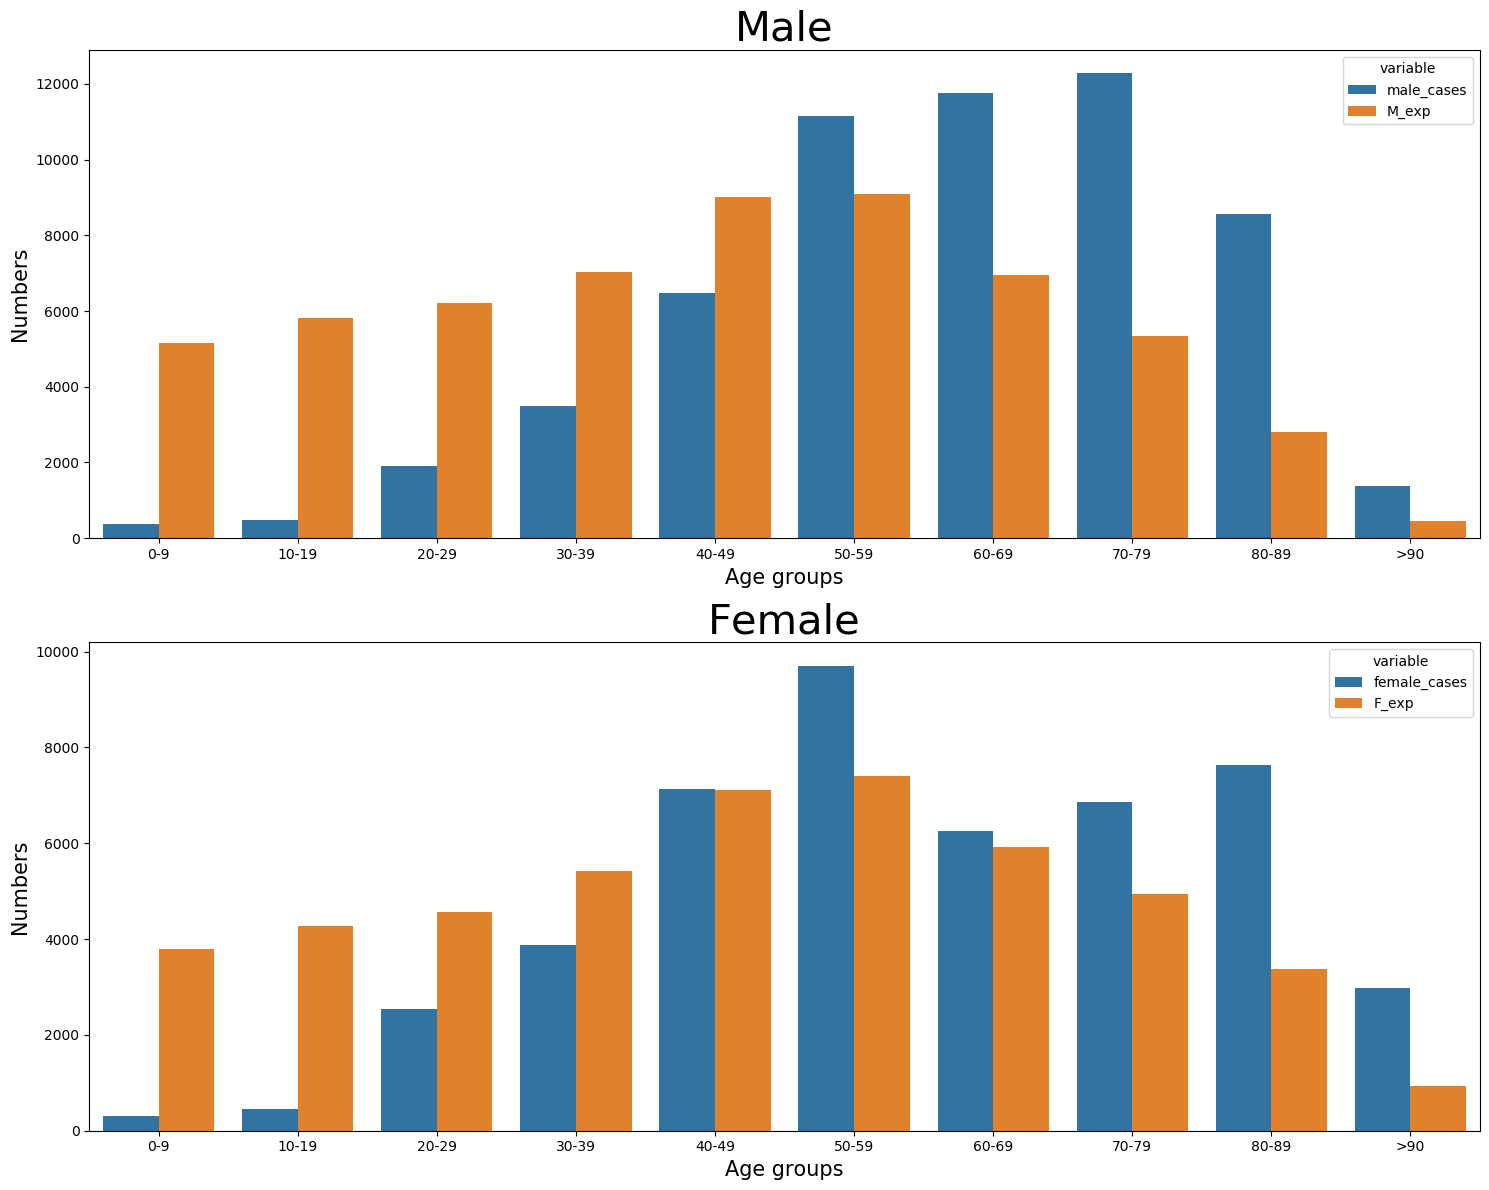

In [1000]:
italy_agetest1 = pd.melt(italy_agetest,id_vars=['age_classes'],value_vars=['male_cases','M_exp'])
italy_agetest2 = pd.melt(italy_agetest,id_vars=['age_classes'],value_vars=['female_cases','F_exp'])
fig, ax = plt.subplots(2,1,figsize = (15,12)) 
sns.catplot(x='age_classes',y='value',hue='variable',kind='bar',data=italy_agetest1,ax=ax[0])
sns.catplot(x='age_classes',y='value',hue='variable',kind='bar',data=italy_agetest2,ax=ax[1])
ax[0].set_xlabel('Age groups', fontsize=15); ax[1].set_xlabel('Age groups', fontsize=15);
ax[0].set_ylabel('Numbers', fontsize=15) ; ax[1].set_ylabel('Numbers', fontsize=15) ; 
ax[0].set_title('Male', fontsize=30); ax[1].set_title('Female', fontsize=30);
plt.close(2); plt.close(3); fig.tight_layout()

可以看出，不管是男性还是女性，年轻人特别是19岁以下的人不容易感染新冠病毒。另外，在女性当中，50岁到59岁的群体最容易感染新冠病毒。而在男性当中，最容易感染新冠病毒的群体为70-79岁。

接下来进行卡方检验：

In [1002]:
chisq,p = stats.chisquare(italy_agetest['male_cases'],f_exp=italy_agetest['M_exp'])
print('chi-square value: ',chisq,'\n','p value: ',p)

chi-square value:  41220.87850967678 
 p value:  0.0


对于男性群体,可以看到H0被拒绝，即：**在男性群体中，新冠病毒不是无差别地攻击不同年龄段的人**

In [1003]:
chisq,p = stats.chisquare(italy_agetest['female_cases'],f_exp=italy_agetest['F_exp'])
print('chi-square value: ',chisq,'\n','p value: ',p)

chi-square value:  19332.701122620234 
 p value:  0.0


对于女性群体,可以看到H0同样被拒绝，即：**在女性群体中，新冠病毒不是无差别地攻击不同年龄段的人**

接下来进行第二步，用卡方检测检验不同年龄段中，新冠病毒是否无差别攻击不同性别的人

第i个原假设H0：在第i个年龄段中，新冠病毒无差别攻击各个性别。

计算不同性别不同年龄段的真实数据和第i个原假设H0成立的前提下的期望值：

In [1004]:
italy_case = pd.read_csv('../data/covid-age.csv',index_col=0)  #意大利3月19号到4月2号期间病例样本
italy_pop0 = pd.read_csv('../data/Italy-2019.csv')  #意大利真实人口数据
#若H0成立，按照真实人口数据求各个年龄段不同性别的病例的期望值
M_proportion = np.random.randn(10); F_proportion = np.random.randn(10)
for i in range(0,9):
    M = (italy_pop0.iloc[2*i:2*i+2,:].sum().M); F = (italy_pop0.iloc[2*i:2*i+2,:].sum().F)
    F_proportion[i] = F/(M+F);
    M_proportion[i] = M/(M+F);
    
M = (italy_pop0.iloc[18:,:].sum().M); F = (italy_pop0.iloc[18:,:].sum().F); 
M_proportion[9] = M/(M+F);
F_proportion[9] = F/(M+F);
italy_sextest = italy_case.iloc[0:10,[0,1,3,5]]
italy_sextest['M_exp'] = [round(M_proportion[i]*italy_sextest['total_cases'][i]) for i in range(10)]
italy_sextest['F_exp'] = [round(F_proportion[i]*italy_sextest['total_cases'][i]) for i in range(10)]
italy_sextest

,age_classes,male_cases,female_cases,total_cases,M_exp,F_exp
0,0-9,381,307,693,357.0,336.0
1,10-19,475,454,931,480.0,451.0
2,20-29,1919,2531,4530,2336.0,2194.0
3,30-39,3505,3885,7466,3757.0,3709.0
4,40-49,6480,7130,13701,6817.0,6884.0
5,50-59,11149,9706,20975,10278.0,10697.0
6,60-69,11761,6254,18089,8652.0,9437.0
7,70-79,12281,6868,19238,8808.0,10430.0
8,80-89,8553,7644,16252,6391.0,9861.0
9,>90,1374,2973,4356,1219.0,3137.0


In [1005]:
#利用Holm-Bonferroni方法计算各个年龄段中改进的p值
chisq,p = np.random.randn(10),np.random.randn(10)
for i in range(len(italy_sextest)):
    f_obs = [italy_sextest.iloc[i,1],italy_sextest.iloc[i,2]]
    f_exp = [italy_sextest.iloc[i,4],italy_sextest.iloc[i,5]]
    chisq[i],p[i] = stats.chisquare(f_obs = f_obs,f_exp=f_exp)
if_reject,adj_p,adj_alpha,alpha =  smt.multipletests(p, alpha=0.01, method='holm')  
list(zip(italy_sextest['age_classes'],adj_p,if_reject))

[('0-9', 0.08493763851801121, False),
 ('10-19', 0.7883908266616757, False),
 ('20-29', 1.6661578227166538e-28, True),
 ('30-39', 1.8155260062752706e-06, True),
 ('40-49', 1.8155260062752706e-06, True),
 ('50-59', 4.685155190111863e-37, True),
 ('60-69', 0.0, True),
 ('70-79', 0.0, True),
 ('80-89', 1.6163681599012585e-268, True),
 ('>90', 5.24177465290453e-07, True)]

上面的结果中，第一列是不同的年龄段，第二列是第i个原假设H0成立的改进的p值，最后一列对应原假设是否被拒绝，其中临界值alpha取为0.01。可以看到，**0-19岁的年龄段中，没有足够的证据拒绝原假设，即没有足够证据表明新冠病毒不会无差别地攻击这个年龄段不同性别的人**，这个年龄段的真实数据和期望值如下图：

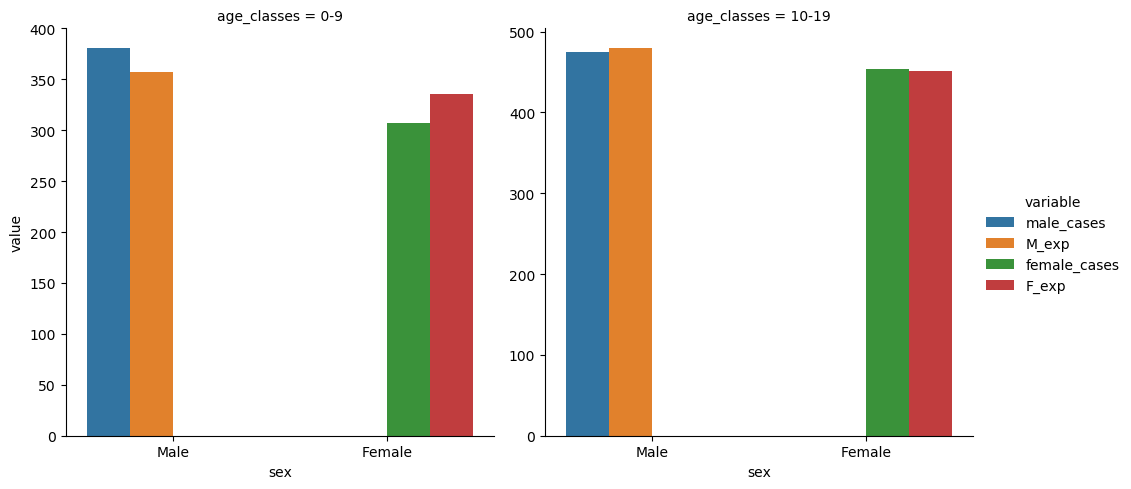

In [1006]:
italy_sextest1 = pd.melt(italy_sextest.iloc[0:2,:],id_vars=['age_classes'],value_vars=['male_cases','M_exp'])
italy_sextest1['sex'] = ['Male']*len(italy_sextest1);
italy_sextest2 = pd.melt(italy_sextest.iloc[0:2,:],id_vars=['age_classes'],value_vars=['female_cases','F_exp'])
italy_sextest2['sex'] = ['Female']*len(italy_sextest2);
italy_sextest3 = pd.concat([italy_sextest1,italy_sextest2],axis=0)
sns.catplot(x='sex',y='value',hue='variable',col="age_classes",kind = 'bar',sharey=False, 
            col_wrap=2,data = italy_sextest3)

**而在大于20岁的人当中，有99%的把握认为新冠病毒会有差别地攻击不同的性别**：

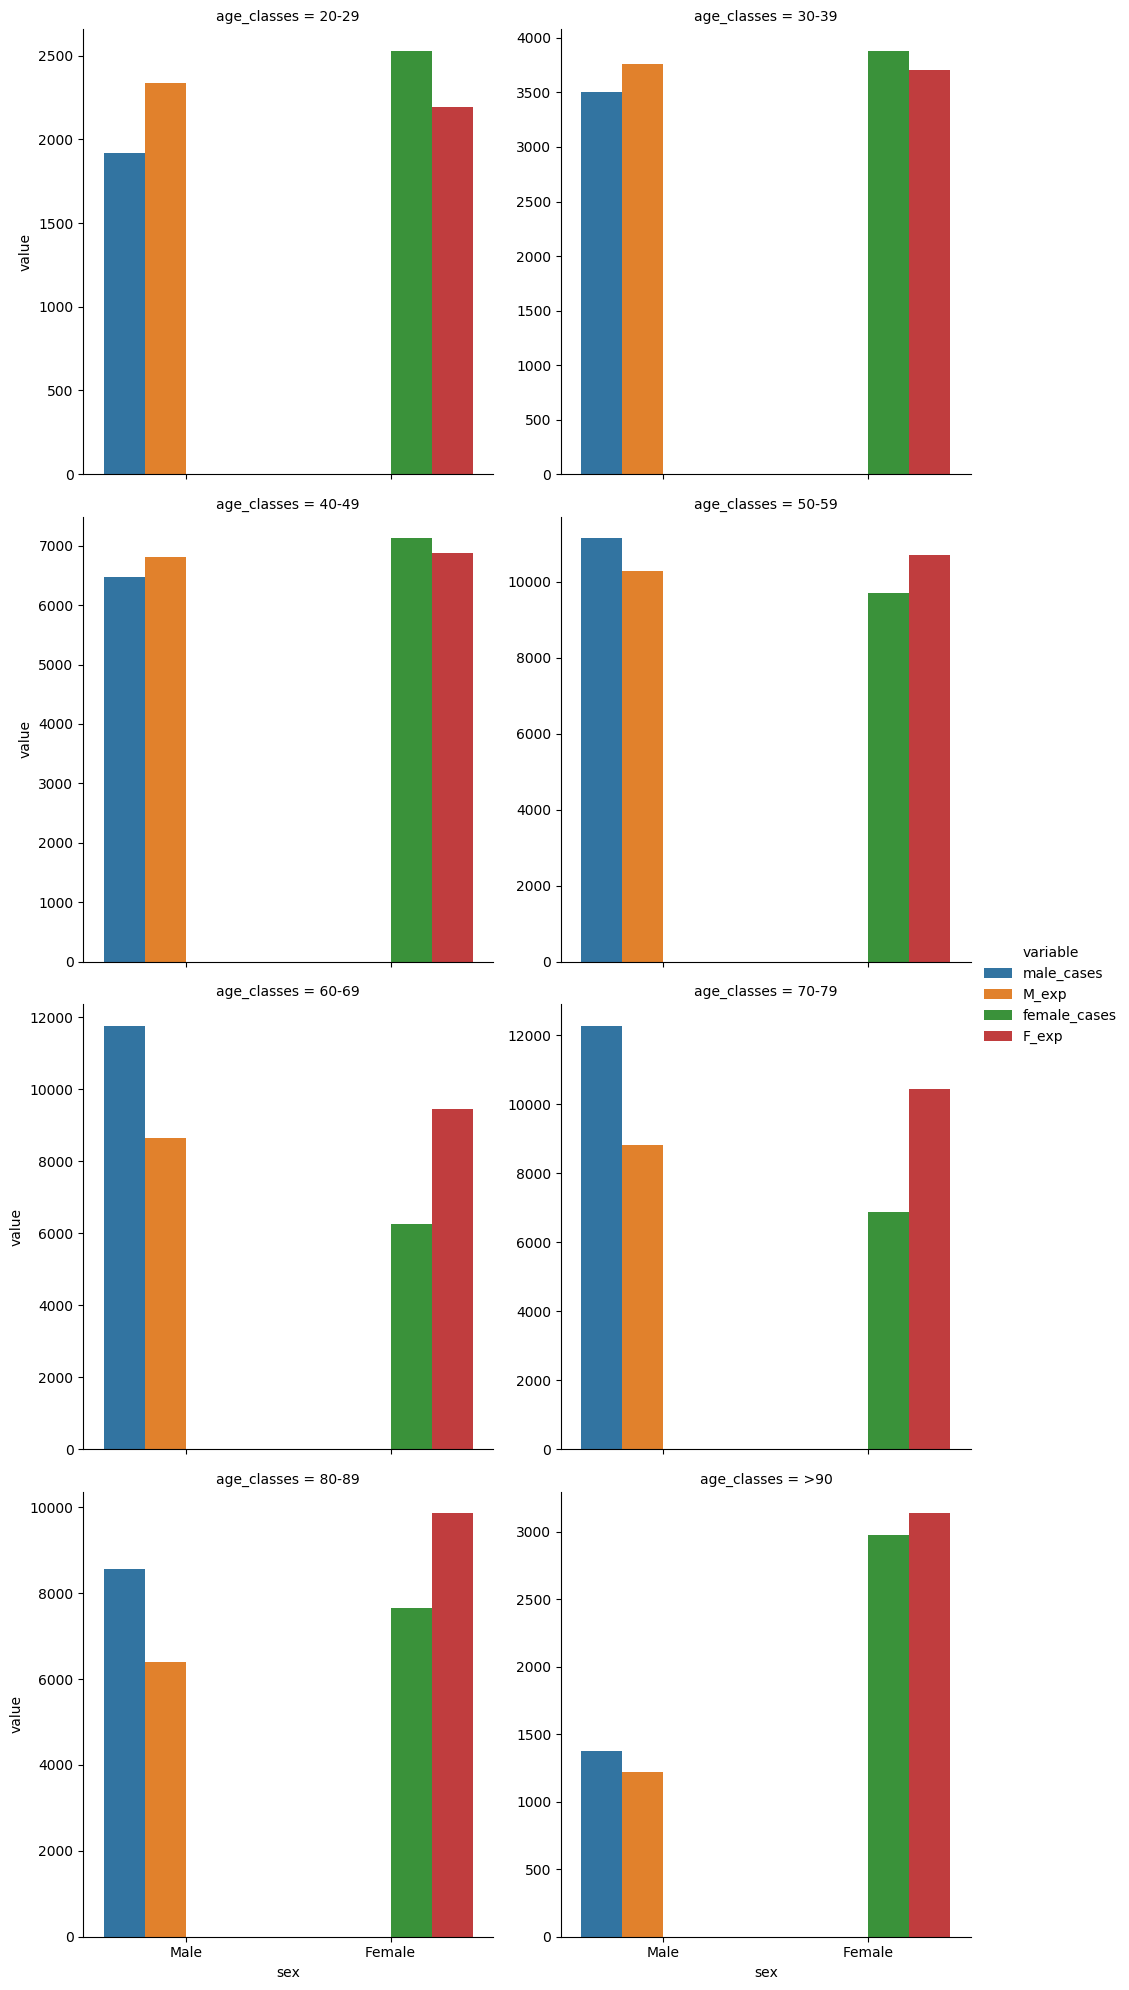

In [1007]:
italy_sextest1 = pd.melt(italy_sextest.iloc[2:,:],id_vars=['age_classes'],value_vars=['male_cases','M_exp'])
italy_sextest1['sex'] = ['Male']*len(italy_sextest1);
italy_sextest2 = pd.melt(italy_sextest.iloc[2:,:],id_vars=['age_classes'],value_vars=['female_cases','F_exp'])
italy_sextest2['sex'] = ['Female']*len(italy_sextest2);
italy_sextest3 = pd.concat([italy_sextest1,italy_sextest2],axis=0)
sns.catplot(x='sex',y='value',hue='variable',col="age_classes",kind = 'bar',sharey=False, 
            col_wrap=2,data = italy_sextest3)

## 结论 <a name="paragraph5"></a>

主要结论：
* 截至2020年4月23日（距离首例报告114天），全球总确诊人数为2588068人，总死亡人数为182808人，确诊率为0.03%，死亡率为7.06%.
* 本文对全球，各大洲，还有总确诊数前五的国家的疫情变化进行了可视化，并分别统计了总确诊人数，总死亡人数，确诊率，死亡率的前20个国家排名。
* 本文对全球总确诊人数和全球总死亡人数进行了多项式拟合，最后结果为：全球总确诊人数在2020年4月23日附近近似3次增长，而全球总死亡人数在2020年4月23日附近近似2次增长。
* 本文以意大利的数据为样本，利用卡方检验分析了新冠病毒是否无差别攻击不同的性别和年龄段群体。最后发现：1.不管是男性群体还是女性群体，新冠病毒都是有差别地攻击不同年龄段的人。年轻人特别是19岁以下的人不容易感染新冠病毒。另外，在女性当中，50岁到59岁的群体最容易感染新冠病毒。而在男性当中，最容易感染新冠病毒的群体为70-79岁。2.在0-19岁的年龄段中，没有足够证据表明新冠病毒不会无差别地攻击这个年龄段不同性别的人，而在大于20岁的人当中，有99%的把握认为新冠病毒会有差别地攻击不同的性别的人群。
 
最后，希望每个人都能安全地度过此次疫情，人类加油！


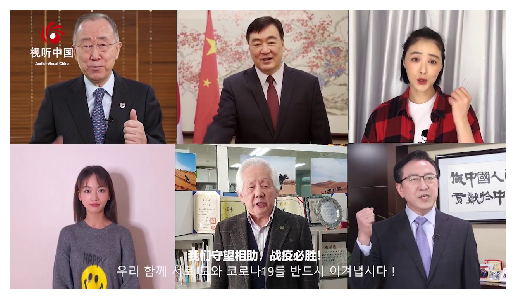

In [1010]:
import matplotlib.image as mpimg
pic = mpimg.imread('战役必胜.jpg'); plt.imshow(pic) 
lena.shape #(512, 512, 3) plt.axis('off') ; plt.show()